In [102]:
!pip install prophet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics

In [104]:
# Imported Fact Order dataset
factOrder_df = pd.read_csv('FactOrder.csv')


# Find number of rows and columns of the dataset
print(factOrder_df.shape)

(1399850, 16)


In [105]:
factOrder_df

OrderNumber  OrderRowNumber  ArticleKey    ArticleName      Colour  \
0           94444500               1       31182  Artikel 31182         NaN   
1           94543600               2       47942  Artikel 47942         red   
2           94543600               3        6763   Artikel 6763  light grey   
3           94543700               1       20870  Artikel 20870    offwhite   
4           94543700               2       38070  Artikel 38070  light grey   
...              ...             ...         ...            ...         ...   
1399845    116135100               3       56158  Artikel 56158        Blue   
1399846    116135100               4       33839  Artikel 33839        Blue   
1399847    116135100               5       54492  Artikel 54492    Offwhite   
1399848    116135100               6       35487  Artikel 35487    Offwhite   
1399849    116135100               7       12249  Artikel 12249        Blue   

             ArticleGenre     Size ArticleGroupName Collection   SizeGroup  \
0                  Övrigt      NaN              VAT       Base         NaN   
1        DRESSES LS WOVEN  116/122          DRESSES       Main  6[116-122]   
2             SWEATSHIRTS    92/98             TOPS       Main    4[92-98]   
3                 TEES LS    80/86             TOPS       Main    3[80-86]   
4             SWEATSHIRTS    80/86             TOPS       Main    3[80-86]   
...                   ...      ...              ...        ...         ...   
1399845           TEES LS  104/110             TOPS       Main  5[104-110]   
1399846   TROUSERS JERSEY    92/98          BOTTOMS       Main    4[92-98]   
1399847          LEGGINGS    92/98          BOTTOMS        Pre    4[92-98]   
1399848           TEES SS  104/110             TOPS        Pre  5[104-110]   
1399849    TROUSERS WOVEN  104/110          BOTTOMS        Pre  5[104-110]   

        BabyJunior ArticleMaterial  DateOrderedKey  QuantityOrdered  Amount  \
0              NaN             NaN        20180102              1.0  997.83   
1           3 KIDS             NaN        20180103              1.0  375.69   
2        2 TODDLER             NaN        20180103              1.0  178.75   
3        2 TODDLER             NaN        20180103              1.0  187.53   
4        2 TODDLER             NaN        20180103              1.0  178.75   
...            ...             ...             ...              ...     ...   
1399845     3 KIDS          JERSEY        20201223              1.0   99.04   
1399846  2 TODDLER          JERSEY        20201223              1.0   99.04   
1399847  2 TODDLER          JERSEY        20201223              1.0  104.54   
1399848     3 KIDS          JERSEY        20201223              1.0   99.04   
1399849     3 KIDS           DENIM        20201223              1.0  198.08   

          Cost  
0         0.00  
1        70.67  
2        68.44  
3        25.67  
4        68.44  
...        ...  
1399845  47.75  
1399846  46.61  
1399847  47.58  
1399848  45.55  
1399849  92.28  

[1399850 rows x 16 columns]

In [106]:
# Get column datatypes and check for null values
factOrder_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399850 entries, 0 to 1399849
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   OrderNumber       1399850 non-null  int64  
 1   OrderRowNumber    1399850 non-null  int64  
 2   ArticleKey        1399850 non-null  int64  
 3   ArticleName       1399850 non-null  object 
 4   Colour            1385814 non-null  object 
 5   ArticleGenre      1399705 non-null  object 
 6   Size              1385789 non-null  object 
 7   ArticleGroupName  1399850 non-null  object 
 8   Collection        1399705 non-null  object 
 9   SizeGroup         1379516 non-null  object 
 10  BabyJunior        1379516 non-null  object 
 11  ArticleMaterial   1140321 non-null  object 
 12  DateOrderedKey    1399850 non-null  int64  
 13  QuantityOrdered   1399850 non-null  float64
 14  Amount            1399850 non-null  float64
 15  Cost              1399850 non-null  float64
dtype

In [107]:
# Check for null values
factOrder_df.isnull().sum()

OrderNumber              0
OrderRowNumber           0
ArticleKey               0
ArticleName              0
Colour               14036
ArticleGenre           145
Size                 14061
ArticleGroupName         0
Collection             145
SizeGroup            20334
BabyJunior           20334
ArticleMaterial     259529
DateOrderedKey           0
QuantityOrdered          0
Amount                   0
Cost                     0
dtype: int64

In [108]:
# Check for duplicates
factOrder_df_dup = factOrder_df[factOrder_df.duplicated(keep='first')]
factOrder_df_dup

Empty DataFrame
Columns: [OrderNumber, OrderRowNumber, ArticleKey, ArticleName, Colour, ArticleGenre, Size, ArticleGroupName, Collection, SizeGroup, BabyJunior, ArticleMaterial, DateOrderedKey, QuantityOrdered, Amount, Cost]
Index: []

In [109]:
factOrder_df.describe()

OrderNumber  OrderRowNumber    ArticleKey  DateOrderedKey  \
count  1.399850e+06    1.399850e+06  1.399850e+06    1.399850e+06   
mean   1.040100e+08    6.669433e+01  2.900643e+04    2.019142e+07   
std    6.179538e+06    1.246381e+02  1.653483e+04    8.317560e+03   
min    9.444450e+07    1.000000e+00 -1.000000e+00    2.018010e+07   
25%    9.801720e+07    2.000000e+00  1.472000e+04    2.018083e+07   
50%    1.040609e+08    1.100000e+01  2.946900e+04    2.019071e+07   
75%    1.091994e+08    7.800000e+01  4.337800e+04    2.020042e+07   
max    1.161351e+08    7.333000e+03  5.729700e+04    2.021010e+07   

       QuantityOrdered        Amount          Cost  
count     1.399850e+06  1.399850e+06  1.399850e+06  
mean      8.941265e+00  4.112368e+02  2.426276e+02  
std       7.283818e+02  5.487492e+03  2.169118e+03  
min      -3.000000e+00 -1.075200e+03 -2.538820e+03  
25%       1.000000e+00  1.115500e+02  4.885000e+01  
50%       1.000000e+00  2.060800e+02  7.872000e+01  
75%       2.000000e+00  3.579500e+02  1.517300e+02  
max       9.710100e+04  3.854246e+06  2.147798e+06

In [110]:
train_end_year = '2019'
article_dimension = 'ArticleGenre' # 'ArticleGenre' 'ArticleGroupName' 'ArticleKey' 'Colour' 'BabyJunior' 'ArticleMaterial' 'Size' 'Collection' 'SizeGroup'

#factOrder_df = factOrder_df[(factOrder_df['QuantityOrdered'] >= 0) & (factOrder_df['QuantityOrdered'] <= 100)]
#factOrder_df = factOrder_df[factOrder_df['QuantityOrdered'] <= 50]
#factOrder_df['QuantityOrdered'] = factOrder_df['QuantityOrdered'] / abs(factOrder_df['QuantityOrdered'])

In [111]:
factOrder_df['DateOrderedKey'] = factOrder_df['DateOrderedKey'].astype(str)
#factOrder_df['DateOrderedMonth'] = pd.to_datetime(factOrder_df['DateOrderedKey'])
#factOrder_df['DateOrderedMonth'] = factOrder_df['DateOrderedMonth'].dt.strftime('%m-%Y')

#factOrder_df = factOrder_df.drop('DateOrderedKey', axis=1)
factOrder_df

OrderNumber  OrderRowNumber  ArticleKey    ArticleName      Colour  \
0           94444500               1       31182  Artikel 31182         NaN   
1           94543600               2       47942  Artikel 47942         red   
2           94543600               3        6763   Artikel 6763  light grey   
3           94543700               1       20870  Artikel 20870    offwhite   
4           94543700               2       38070  Artikel 38070  light grey   
...              ...             ...         ...            ...         ...   
1399845    116135100               3       56158  Artikel 56158        Blue   
1399846    116135100               4       33839  Artikel 33839        Blue   
1399847    116135100               5       54492  Artikel 54492    Offwhite   
1399848    116135100               6       35487  Artikel 35487    Offwhite   
1399849    116135100               7       12249  Artikel 12249        Blue   

             ArticleGenre     Size ArticleGroupName Collection   SizeGroup  \
0                  Övrigt      NaN              VAT       Base         NaN   
1        DRESSES LS WOVEN  116/122          DRESSES       Main  6[116-122]   
2             SWEATSHIRTS    92/98             TOPS       Main    4[92-98]   
3                 TEES LS    80/86             TOPS       Main    3[80-86]   
4             SWEATSHIRTS    80/86             TOPS       Main    3[80-86]   
...                   ...      ...              ...        ...         ...   
1399845           TEES LS  104/110             TOPS       Main  5[104-110]   
1399846   TROUSERS JERSEY    92/98          BOTTOMS       Main    4[92-98]   
1399847          LEGGINGS    92/98          BOTTOMS        Pre    4[92-98]   
1399848           TEES SS  104/110             TOPS        Pre  5[104-110]   
1399849    TROUSERS WOVEN  104/110          BOTTOMS        Pre  5[104-110]   

        BabyJunior ArticleMaterial DateOrderedKey  QuantityOrdered  Amount  \
0              NaN             NaN       20180102              1.0  997.83   
1           3 KIDS             NaN       20180103              1.0  375.69   
2        2 TODDLER             NaN       20180103              1.0  178.75   
3        2 TODDLER             NaN       20180103              1.0  187.53   
4        2 TODDLER             NaN       20180103              1.0  178.75   
...            ...             ...            ...              ...     ...   
1399845     3 KIDS          JERSEY       20201223              1.0   99.04   
1399846  2 TODDLER          JERSEY       20201223              1.0   99.04   
1399847  2 TODDLER          JERSEY       20201223              1.0  104.54   
1399848     3 KIDS          JERSEY       20201223              1.0   99.04   
1399849     3 KIDS           DENIM       20201223              1.0  198.08   

          Cost  
0         0.00  
1        70.67  
2        68.44  
3        25.67  
4        68.44  
...        ...  
1399845  47.75  
1399846  46.61  
1399847  47.58  
1399848  45.55  
1399849  92.28  

[1399850 rows x 16 columns]

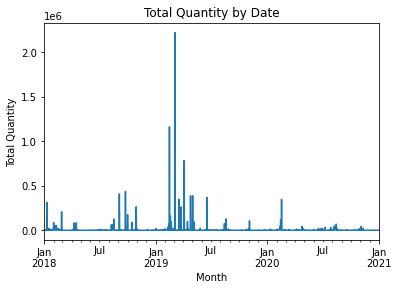

In [112]:
factOrder_df.DateOrderedKey =  pd.to_datetime(factOrder_df['DateOrderedKey'], format= '%Y-%m-%d')

total_by_date = factOrder_df.groupby(pd.to_datetime(factOrder_df['DateOrderedKey'], format= '%Y-%m'))['QuantityOrdered'].sum().fillna(0)
total_by_date.plot()
plt.title('Total Quantity by Date')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.show()

# Preprocessing the dataset

In [113]:
article_dimension_df = pd.DataFrame(factOrder_df[article_dimension].dropna().unique(), columns=[article_dimension])
article_dimension_df

ArticleGenre
0             Övrigt
1   DRESSES LS WOVEN
2        SWEATSHIRTS
3            TEES LS
4            TEES SS
..               ...
79           Jackets
80         Postcards
81             Party
82             Shoes
83    JUMPSUIT WOVEN

[84 rows x 1 columns]

In [114]:
#factOrder_df = factOrder_df.groupby(['DateOrderedKey']).sum('QuantityOrdered').fillna(0)
factOrder_df = factOrder_df.groupby(['DateOrderedKey', article_dimension]).sum('QuantityOrdered').fillna(0)
factOrder_df = factOrder_df.reset_index()
factOrder_df = factOrder_df[['DateOrderedKey', 'QuantityOrdered', article_dimension]]

factOrder_df

DateOrderedKey  QuantityOrdered       ArticleGenre
0         2018-01-01             29.0            BEANIES
1         2018-01-01              2.0           BEDDINGS
2         2018-01-01              8.0            BODY LS
3         2018-01-01              2.0            BODY SS
4         2018-01-01              1.0          BODY WRAP
...              ...              ...                ...
48444     2021-01-01              3.0  TROUSERS UNPADDED
48445     2021-01-01              1.0       TROUSERS WCT
48446     2021-01-01              3.0     TROUSERS WOVEN
48447     2021-01-01              3.0          UNDERWEAR
48448     2021-01-01              1.0            UV TOPS

[48449 rows x 3 columns]

In [115]:
# Creating the common function for splitting the dataset into test and train samples
def CreateSplitTestAndTrainData(df_model):
    # Splitting the dataset into training and test    
    train = df_model[pd.to_datetime(df_model['ds']).dt.strftime('%Y') <= train_end_year]
    test = df_model[pd.to_datetime(df_model['ds']).dt.strftime('%Y') > train_end_year]
        
    return train, test

In [116]:
def CreateModel(train):
    
    model = Prophet(weekly_seasonality=False)
    #model = Prophet()
    
    # Enable monthly seasonality
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
       
    # Fitting the model with the training dataset
    model.fit(train)
    
    return model

In [117]:
def ModelPrediction(model):
    # Create future dates for prediction
    future_dates = model.make_future_dataframe(periods=12, freq='MS')
  #  future_dates = model.make_future_dataframe(periods=365, freq='D')

    # Make predictions for future dates
    predictions = model.predict(future_dates)

    # Plot the prediction
    model.plot(predictions);
    #print(predictions)
    
    return predictions
    
    # Plot the prediction components
   # model.plot_components(predictions);

21:34:17 - cmdstanpy - INFO - Chain [1] start processing
21:34:17 - cmdstanpy - INFO - Chain [1] done processing


Övrigt


21:34:17 - cmdstanpy - INFO - Chain [1] start processing


DRESSES LS WOVEN


21:34:17 - cmdstanpy - INFO - Chain [1] done processing
21:34:18 - cmdstanpy - INFO - Chain [1] start processing


SWEATSHIRTS


21:34:18 - cmdstanpy - INFO - Chain [1] done processing
21:34:18 - cmdstanpy - INFO - Chain [1] start processing


TEES LS


21:34:18 - cmdstanpy - INFO - Chain [1] done processing
21:34:19 - cmdstanpy - INFO - Chain [1] start processing


TEES SS


21:34:19 - cmdstanpy - INFO - Chain [1] done processing
21:34:19 - cmdstanpy - INFO - Chain [1] start processing


DRESSES LS


21:34:19 - cmdstanpy - INFO - Chain [1] done processing
21:34:20 - cmdstanpy - INFO - Chain [1] start processing


LEGGINGS


21:34:20 - cmdstanpy - INFO - Chain [1] done processing
21:34:20 - cmdstanpy - INFO - Chain [1] start processing


DRESSES SS


21:34:20 - cmdstanpy - INFO - Chain [1] done processing
21:34:21 - cmdstanpy - INFO - Chain [1] start processing
21:34:21 - cmdstanpy - INFO - Chain [1] done processing


BEANIES


21:34:21 - cmdstanpy - INFO - Chain [1] start processing


JACKETS UNPADDED


21:34:21 - cmdstanpy - INFO - Chain [1] done processing
21:34:22 - cmdstanpy - INFO - Chain [1] start processing


LEGGINGS NB


21:34:22 - cmdstanpy - INFO - Chain [1] done processing
21:34:22 - cmdstanpy - INFO - Chain [1] start processing
21:34:22 - cmdstanpy - INFO - Chain [1] done processing


SKIRTS


21:34:23 - cmdstanpy - INFO - Chain [1] start processing
21:34:23 - cmdstanpy - INFO - Chain [1] done processing


Dungaree


21:34:23 - cmdstanpy - INFO - Chain [1] start processing
21:34:23 - cmdstanpy - INFO - Chain [1] done processing


ONESIES


21:34:24 - cmdstanpy - INFO - Chain [1] start processing


CAPS


21:34:24 - cmdstanpy - INFO - Chain [1] done processing
21:34:24 - cmdstanpy - INFO - Chain [1] start processing


BODY LS


21:34:24 - cmdstanpy - INFO - Chain [1] done processing
21:34:25 - cmdstanpy - INFO - Chain [1] start processing


SHIRT/BLOUSE


21:34:25 - cmdstanpy - INFO - Chain [1] done processing
21:34:25 - cmdstanpy - INFO - Chain [1] start processing
21:34:25 - cmdstanpy - INFO - Chain [1] done processing


TROUSERS JERSEY


21:34:26 - cmdstanpy - INFO - Chain [1] start processing


SWEATPANTS


21:34:26 - cmdstanpy - INFO - Chain [1] done processing
21:34:26 - cmdstanpy - INFO - Chain [1] start processing


Jumpsuits Baby


21:34:26 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing
21:34:27 - cmdstanpy - INFO - Chain [1] done processing


SWEATDRESSES


C:\Users\Sandeep\anaconda3\lib\site-packages\prophet\plot.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
21:34:27 - cmdstanpy - INFO - Chain [1] start processing
21:34:27 - cmdstanpy - INFO - Chain [1] done processing


BODY WRAP


21:34:27 - cmdstanpy - INFO - Chain [1] start processing
21:34:27 - cmdstanpy - INFO - Chain [1] done processing


SWEATERS


21:34:28 - cmdstanpy - INFO - Chain [1] start processing
21:34:28 - cmdstanpy - INFO - Chain [1] done processing


OVERALLS UNPADDED


21:34:28 - cmdstanpy - INFO - Chain [1] start processing
21:34:28 - cmdstanpy - INFO - Chain [1] done processing


TIGHTS


21:34:29 - cmdstanpy - INFO - Chain [1] start processing
21:34:29 - cmdstanpy - INFO - Chain [1] done processing


BODY SS


21:34:29 - cmdstanpy - INFO - Chain [1] start processing
21:34:29 - cmdstanpy - INFO - Chain [1] done processing


JACKETS PADDED


21:34:30 - cmdstanpy - INFO - Chain [1] start processing


SKIRTS WOVEN


21:34:30 - cmdstanpy - INFO - Chain [1] done processing
21:34:30 - cmdstanpy - INFO - Chain [1] start processing
21:34:30 - cmdstanpy - INFO - Chain [1] done processing


BAGS


21:34:31 - cmdstanpy - INFO - Chain [1] start processing


SOCKS


21:34:31 - cmdstanpy - INFO - Chain [1] done processing
21:34:31 - cmdstanpy - INFO - Chain [1] start processing


FLEECE


21:34:31 - cmdstanpy - INFO - Chain [1] done processing
21:34:32 - cmdstanpy - INFO - Chain [1] start processing
21:34:32 - cmdstanpy - INFO - Chain [1] done processing


OTHER HOME


21:34:32 - cmdstanpy - INFO - Chain [1] start processing
21:34:32 - cmdstanpy - INFO - Chain [1] done processing


SWIMSUITS


21:34:33 - cmdstanpy - INFO - Chain [1] start processing
21:34:33 - cmdstanpy - INFO - Chain [1] done processing


GLOVES


21:34:33 - cmdstanpy - INFO - Chain [1] start processing
21:34:33 - cmdstanpy - INFO - Chain [1] done processing


TROUSERS WOVEN


21:34:34 - cmdstanpy - INFO - Chain [1] start processing


BEDDINGS


21:34:34 - cmdstanpy - INFO - Chain [1] done processing
21:34:34 - cmdstanpy - INFO - Chain [1] start processing
21:34:34 - cmdstanpy - INFO - Chain [1] done processing


Giftbox


21:34:35 - cmdstanpy - INFO - Chain [1] start processing
21:34:35 - cmdstanpy - INFO - Chain [1] done processing


CARDIGANS


21:34:35 - cmdstanpy - INFO - Chain [1] start processing


SUNGLASSES


21:34:35 - cmdstanpy - INFO - Chain [1] done processing
21:34:36 - cmdstanpy - INFO - Chain [1] start processing
21:34:36 - cmdstanpy - INFO - Chain [1] done processing


DRESSES STRAP


21:34:36 - cmdstanpy - INFO - Chain [1] start processing
21:34:36 - cmdstanpy - INFO - Chain [1] done processing


UV TOPS


21:34:36 - cmdstanpy - INFO - Chain [1] start processing
21:34:36 - cmdstanpy - INFO - Chain [1] done processing


JUMPSUITS


21:34:37 - cmdstanpy - INFO - Chain [1] start processing


SHORTS


21:34:37 - cmdstanpy - INFO - Chain [1] done processing
21:34:37 - cmdstanpy - INFO - Chain [1] start processing
21:34:37 - cmdstanpy - INFO - Chain [1] done processing


TANKS


21:34:38 - cmdstanpy - INFO - Chain [1] start processing
21:34:38 - cmdstanpy - INFO - Chain [1] done processing


SWIMSHORTS


21:34:38 - cmdstanpy - INFO - Chain [1] start processing
21:34:38 - cmdstanpy - INFO - Chain [1] done processing


RAIN & SUN HATS


21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing


SWIMPANTS


21:34:39 - cmdstanpy - INFO - Chain [1] start processing
21:34:39 - cmdstanpy - INFO - Chain [1] done processing


OVERALLS PADDED


21:34:39 - cmdstanpy - INFO - Chain [1] start processing


OTHER ACCESSORIES


21:34:40 - cmdstanpy - INFO - Chain [1] done processing
21:34:40 - cmdstanpy - INFO - Chain [1] start processing
21:34:40 - cmdstanpy - INFO - Chain [1] done processing


SHOES


21:34:40 - cmdstanpy - INFO - Chain [1] start processing
21:34:40 - cmdstanpy - INFO - Chain [1] done processing


TROUSERS PADDED


21:34:41 - cmdstanpy - INFO - Chain [1] start processing


DRESSES SS WOVEN


21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] start processing
21:34:41 - cmdstanpy - INFO - Chain [1] done processing


SCARVES/BIBS


21:34:42 - cmdstanpy - INFO - Chain [1] start processing
21:34:42 - cmdstanpy - INFO - Chain [1] done processing


BABY BOOTS


21:34:42 - cmdstanpy - INFO - Chain [1] start processing
21:34:42 - cmdstanpy - INFO - Chain [1] done processing


TROUSERS UNPADDED


21:34:43 - cmdstanpy - INFO - Chain [1] start processing
21:34:43 - cmdstanpy - INFO - Chain [1] done processing


DENIM


21:34:43 - cmdstanpy - INFO - Chain [1] start processing
21:34:43 - cmdstanpy - INFO - Chain [1] done processing


Summersuit


21:34:43 - cmdstanpy - INFO - Chain [1] start processing
21:34:43 - cmdstanpy - INFO - Chain [1] done processing


UV SUITS


21:34:44 - cmdstanpy - INFO - Chain [1] start processing


BABY KIT


21:34:44 - cmdstanpy - INFO - Chain [1] done processing
21:34:44 - cmdstanpy - INFO - Chain [1] start processing
21:34:44 - cmdstanpy - INFO - Chain [1] done processing


BATH


21:34:44 - cmdstanpy - INFO - Chain [1] start processing


Jacket


21:34:45 - cmdstanpy - INFO - Chain [1] done processing
21:34:45 - cmdstanpy - INFO - Chain [1] start processing
21:34:45 - cmdstanpy - INFO - Chain [1] done processing


BODY WOVEN


21:34:46 - cmdstanpy - INFO - Chain [1] start processing
21:34:46 - cmdstanpy - INFO - Chain [1] done processing


SHORTS WOVEN


21:34:46 - cmdstanpy - INFO - Chain [1] start processing


PLAYSUIT


21:34:47 - cmdstanpy - INFO - Chain [1] done processing
21:34:47 - cmdstanpy - INFO - Chain [1] start processing


OUTERWEAR


21:34:49 - cmdstanpy - INFO - Chain [1] done processing
21:34:50 - cmdstanpy - INFO - Chain [1] start processing


INTERIOR


21:34:51 - cmdstanpy - INFO - Chain [1] done processing
21:34:52 - cmdstanpy - INFO - Chain [1] start processing
21:34:52 - cmdstanpy - INFO - Chain [1] done processing


ROBES


21:34:52 - cmdstanpy - INFO - Chain [1] start processing
21:34:52 - cmdstanpy - INFO - Chain [1] done processing


UNDERWEAR


21:34:53 - cmdstanpy - INFO - Chain [1] start processing
21:34:53 - cmdstanpy - INFO - Chain [1] done processing


TOP WCT


21:34:53 - cmdstanpy - INFO - Chain [1] start processing
21:34:53 - cmdstanpy - INFO - Chain [1] done processing


TROUSERS WCT


21:34:53 - cmdstanpy - INFO - Chain [1] start processing


TOP


21:34:59 - cmdstanpy - INFO - Chain [1] done processing
21:34:59 - cmdstanpy - INFO - Chain [1] start processing
21:34:59 - cmdstanpy - INFO - Chain [1] done processing


OTH


21:34:59 - cmdstanpy - INFO - Chain [1] start processing
21:35:00 - cmdstanpy - INFO - Chain [1] done processing


Caps


21:35:00 - cmdstanpy - INFO - Chain [1] start processing
21:35:00 - cmdstanpy - INFO - Chain [1] done processing


KNITTED HATS


21:35:00 - cmdstanpy - INFO - Chain [1] start processing
21:35:00 - cmdstanpy - INFO - Chain [1] done processing


BEANIE BABY


21:35:01 - cmdstanpy - INFO - Chain [1] start processing
21:35:01 - cmdstanpy - INFO - Chain [1] done processing


HOME


21:35:01 - cmdstanpy - INFO - Chain [1] start processing
21:35:01 - cmdstanpy - INFO - Chain [1] done processing


Paperbags store material


21:35:01 - cmdstanpy - INFO - Chain [1] start processing
21:35:01 - cmdstanpy - INFO - Chain [1] done processing


Tee


21:35:02 - cmdstanpy - INFO - Chain [1] start processing


BOV


21:35:02 - cmdstanpy - INFO - Chain [1] done processing
21:35:03 - cmdstanpy - INFO - Chain [1] start processing
21:35:03 - cmdstanpy - INFO - Chain [1] done processing


Jackets


21:35:03 - cmdstanpy - INFO - Chain [1] start processing


Postcards


21:35:03 - cmdstanpy - INFO - Chain [1] done processing


Party
Shoes
JUMPSUIT WOVEN


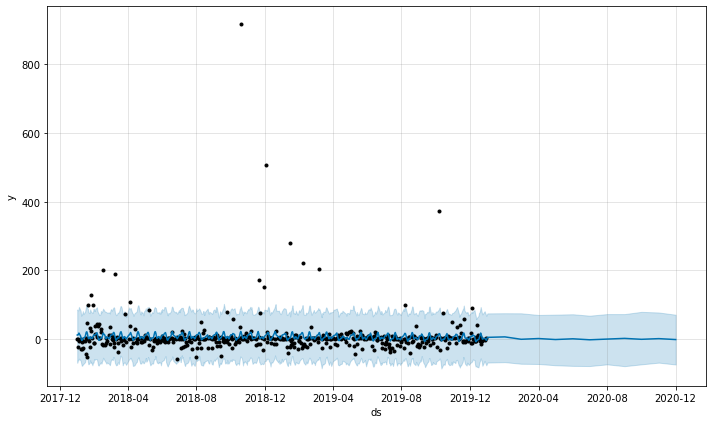

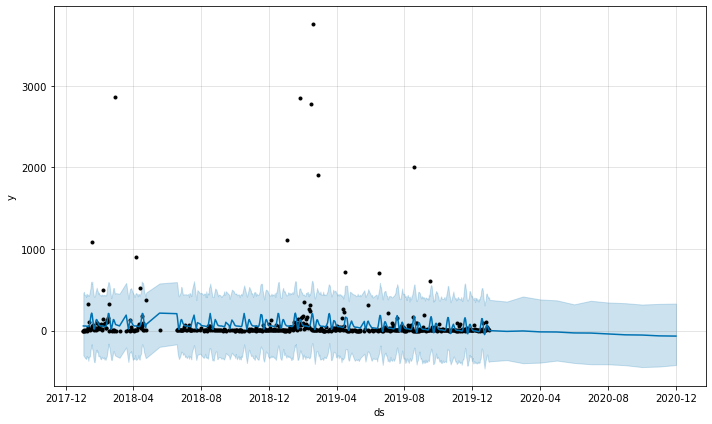

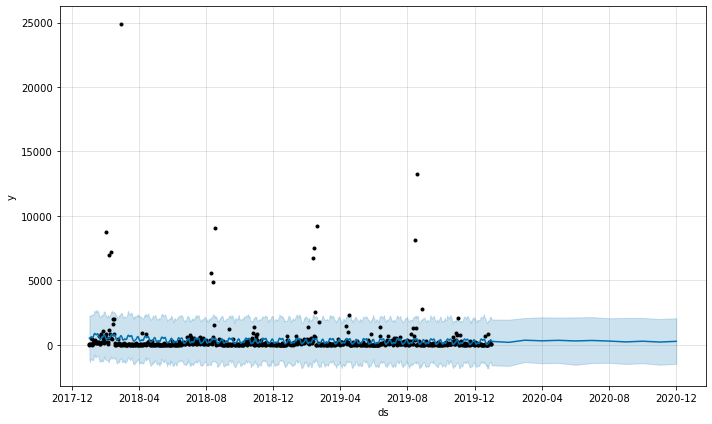

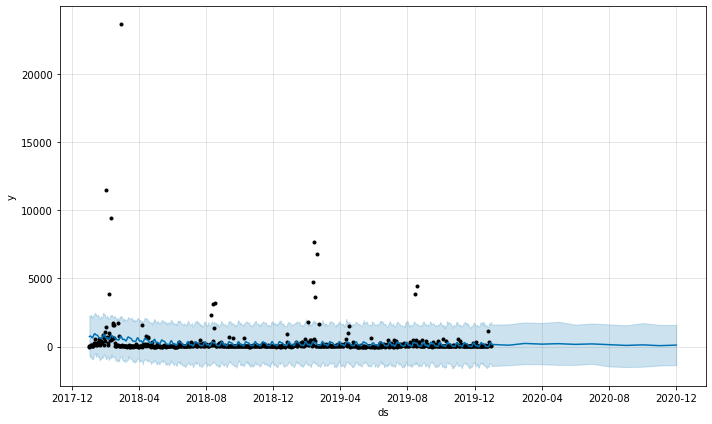

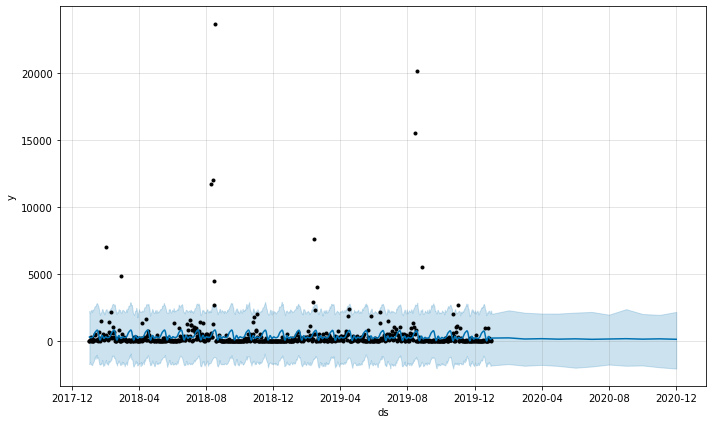

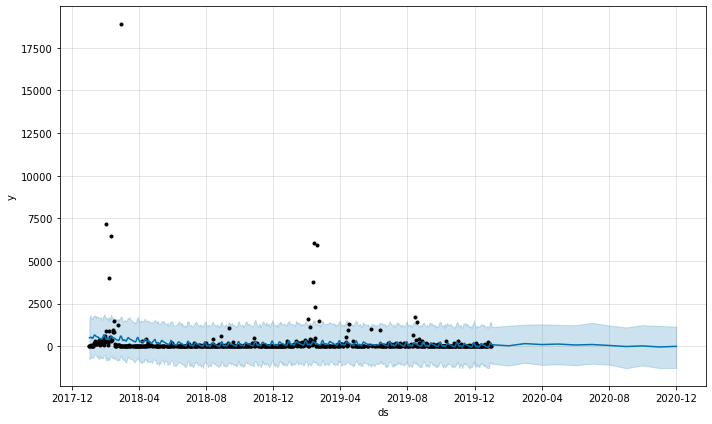

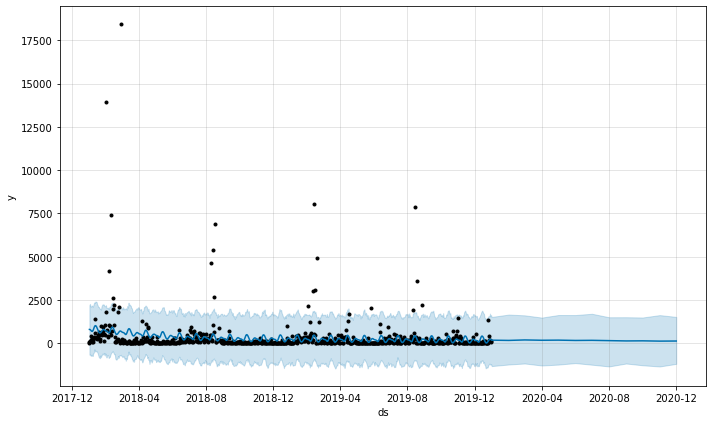

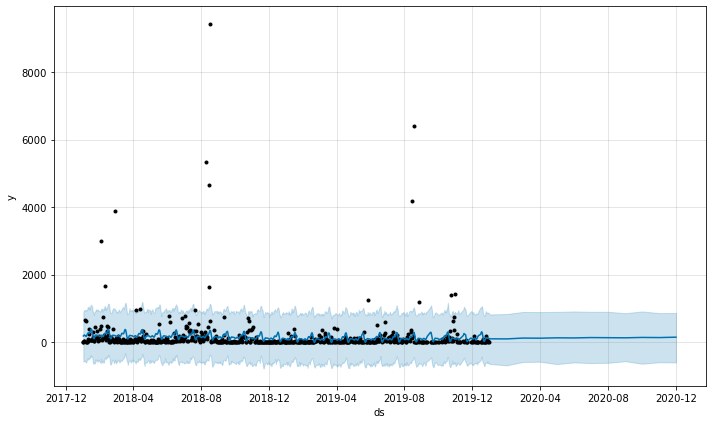

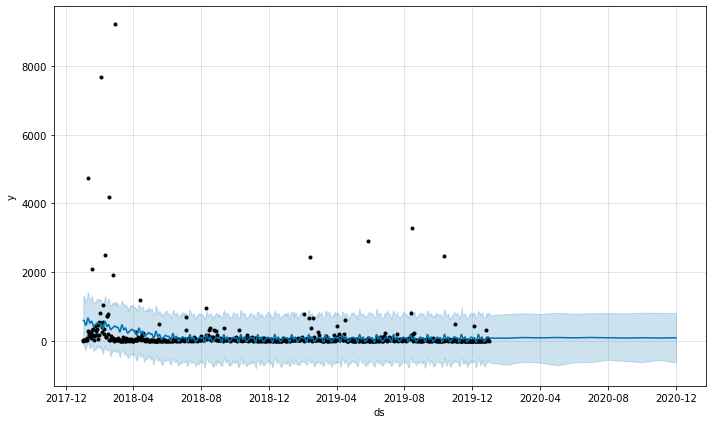

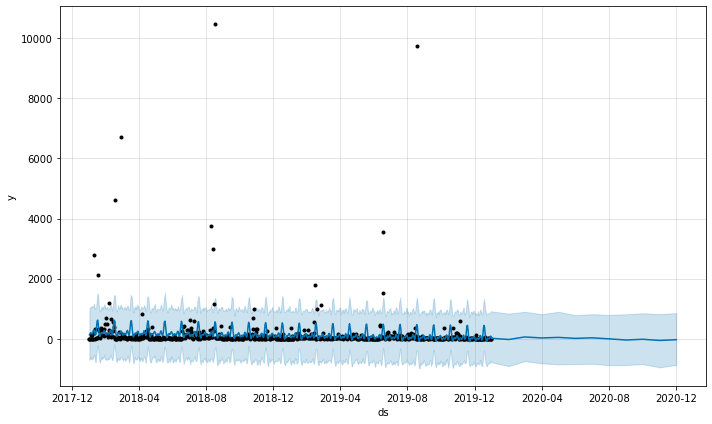

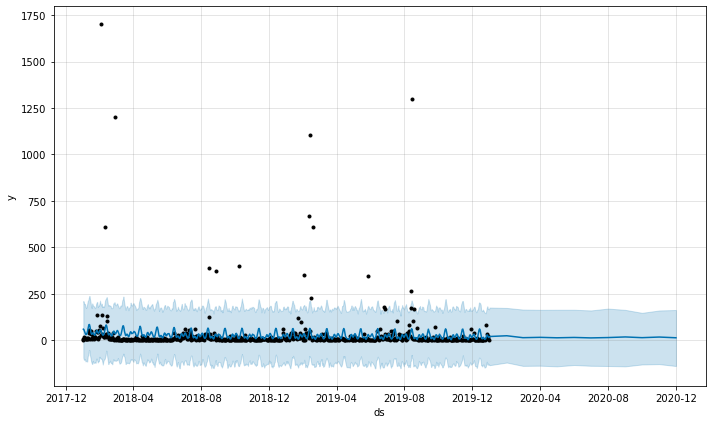

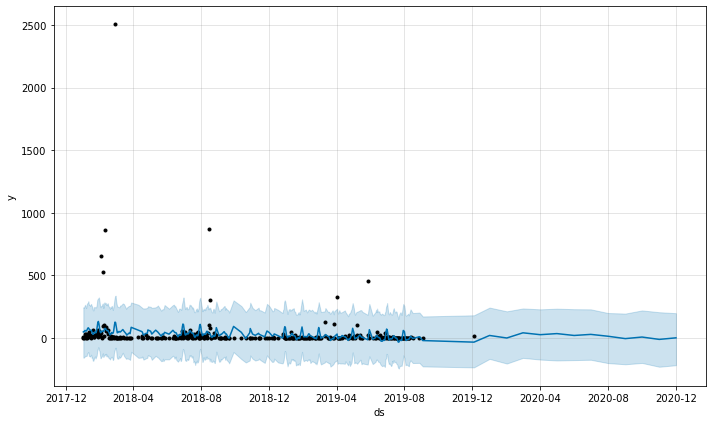

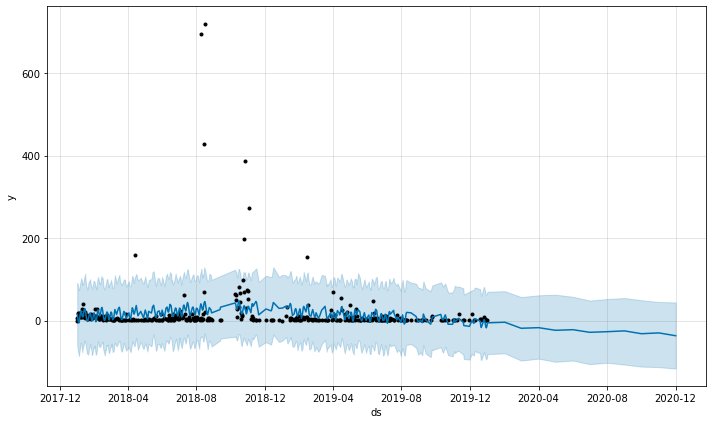

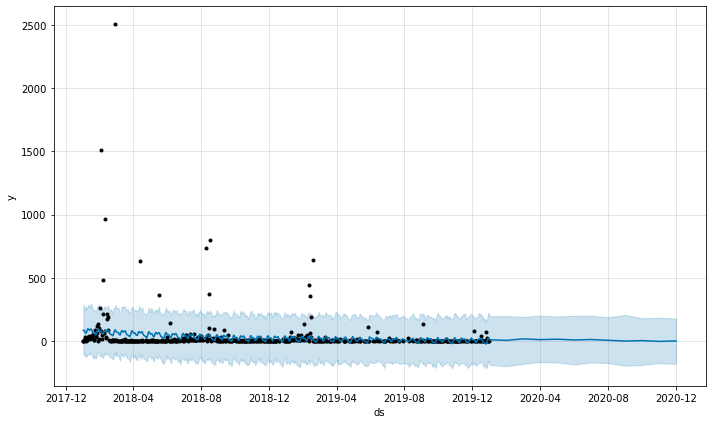

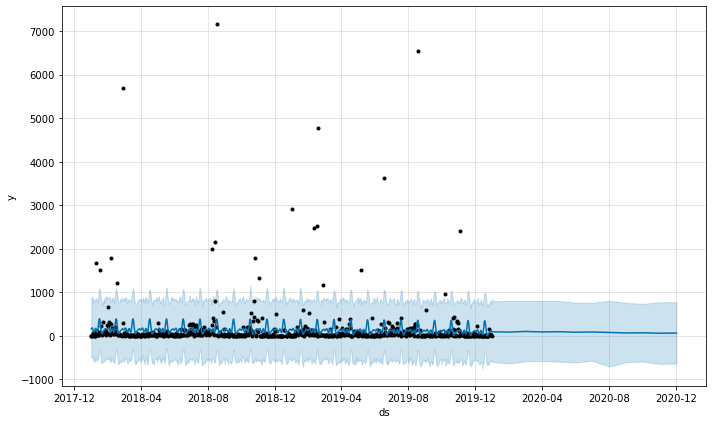

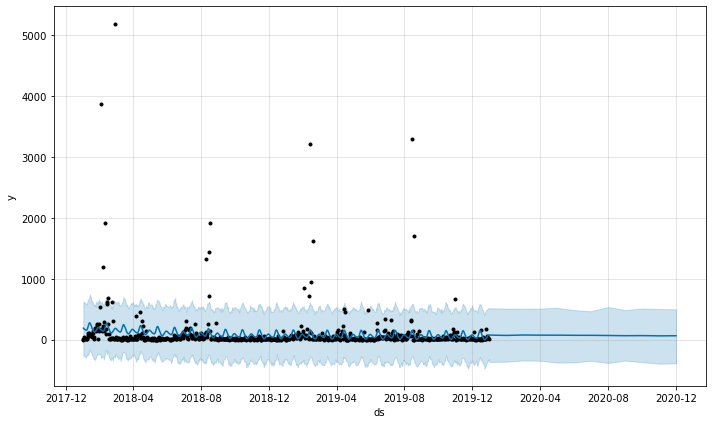

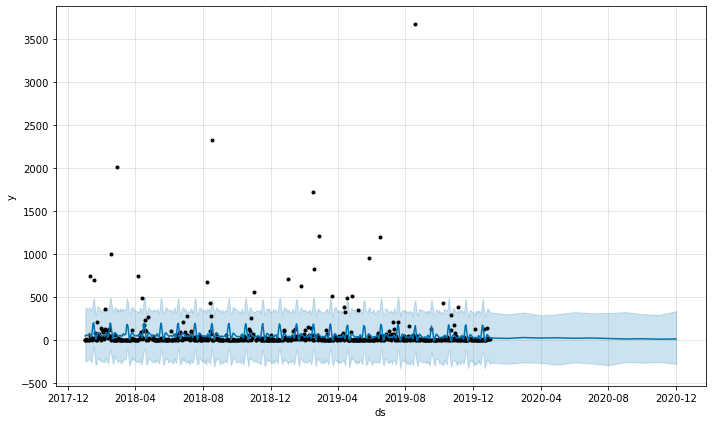

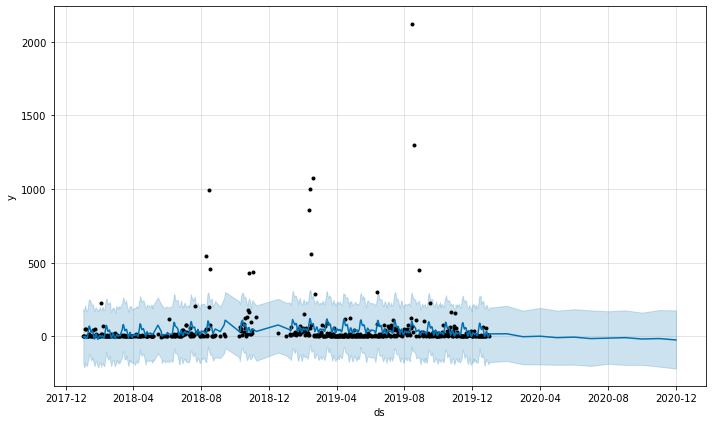

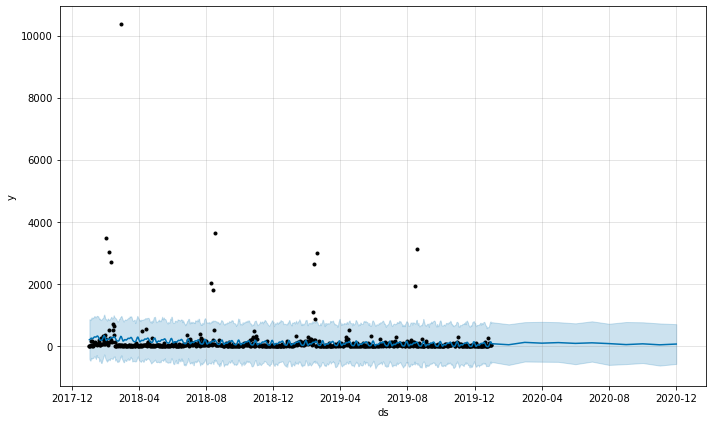

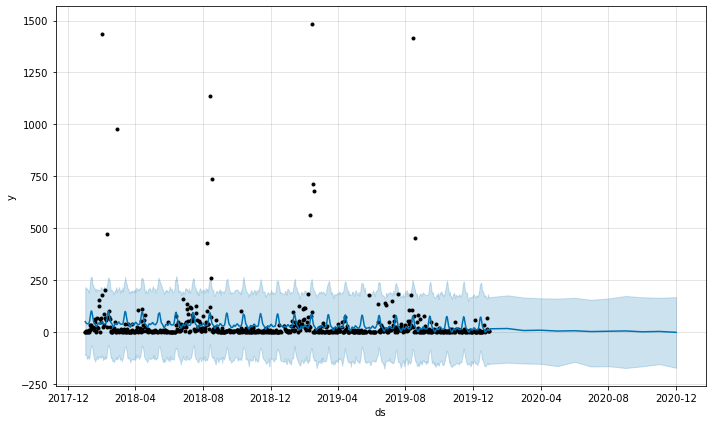

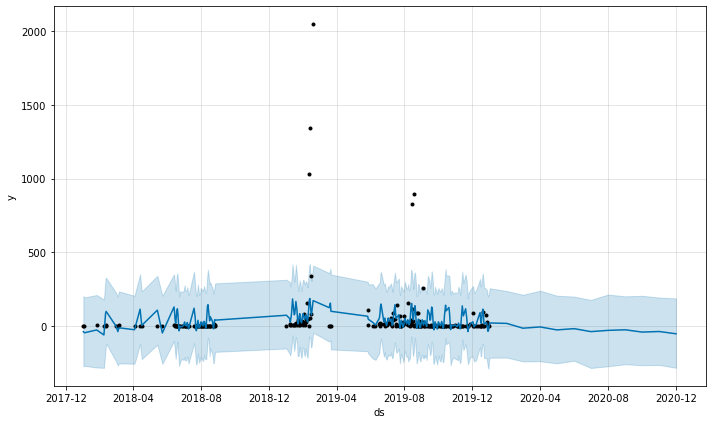

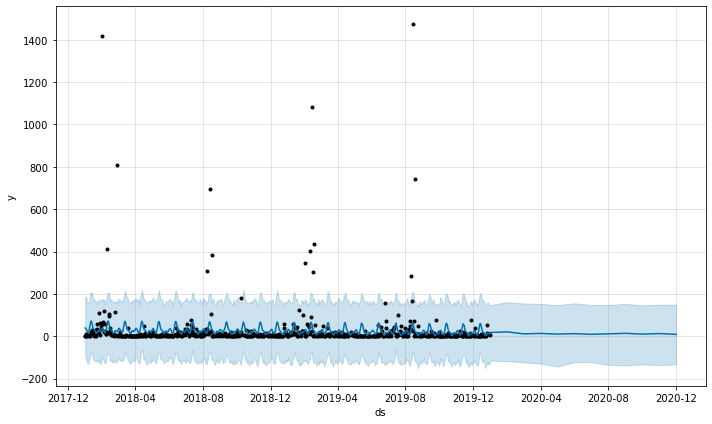

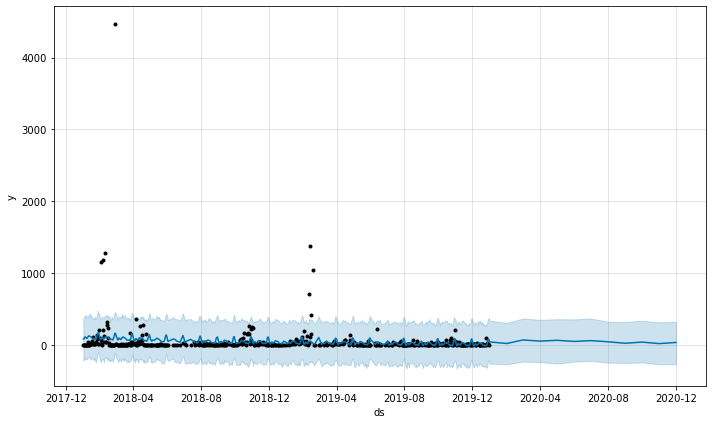

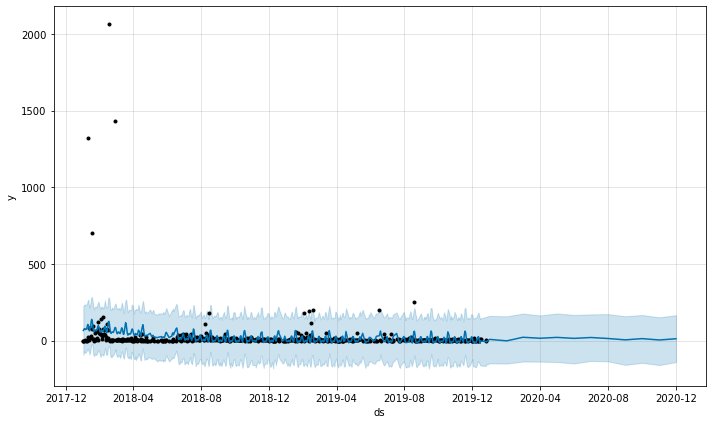

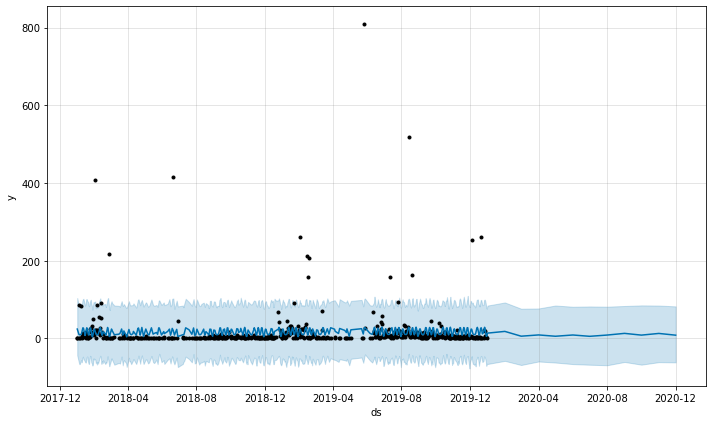

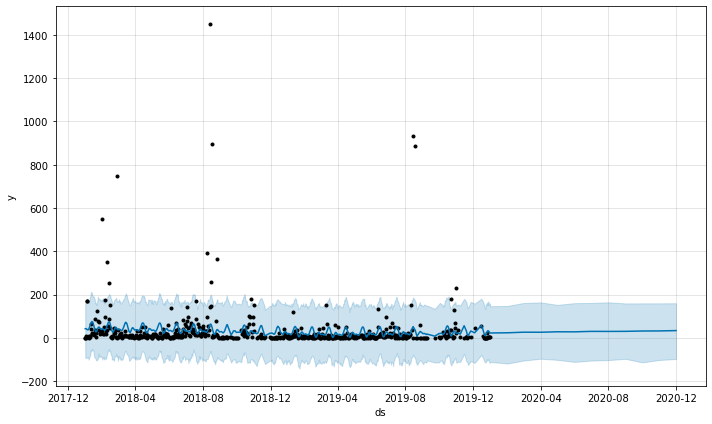

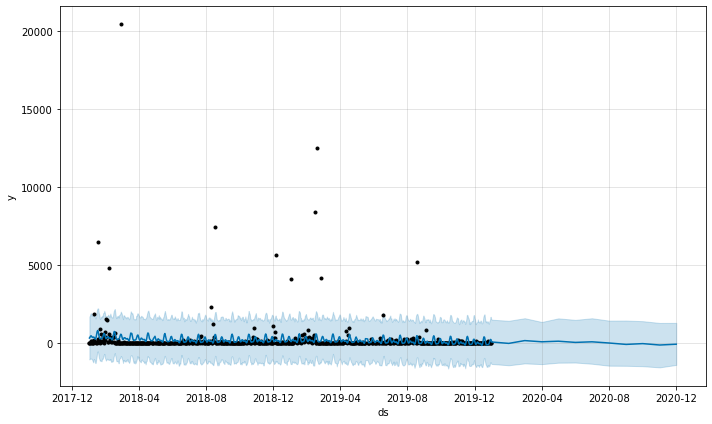

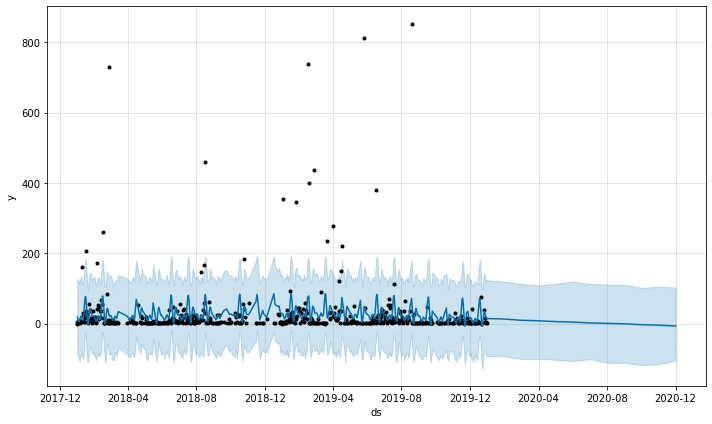

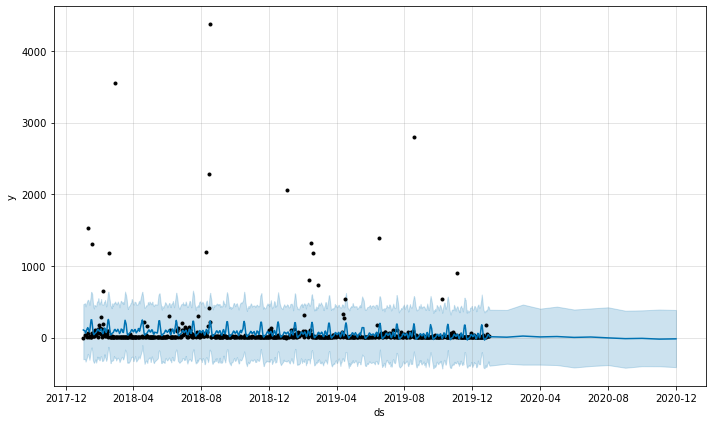

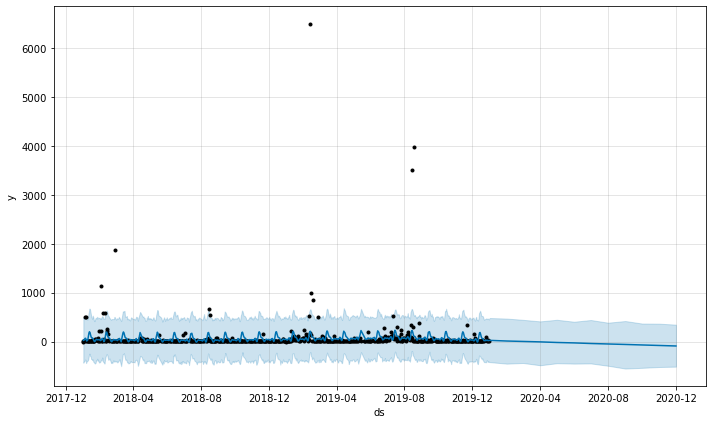

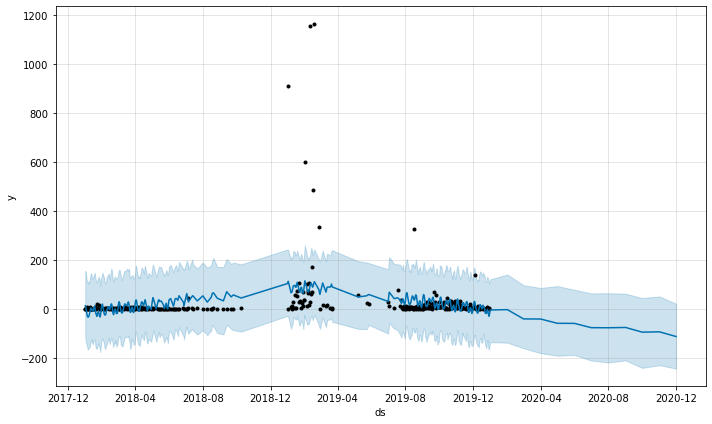

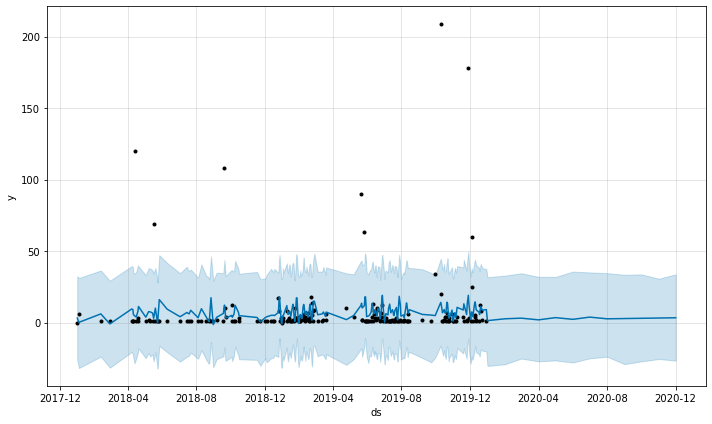

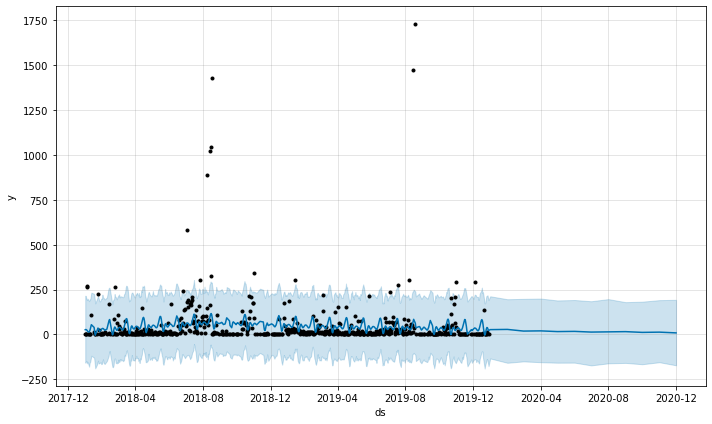

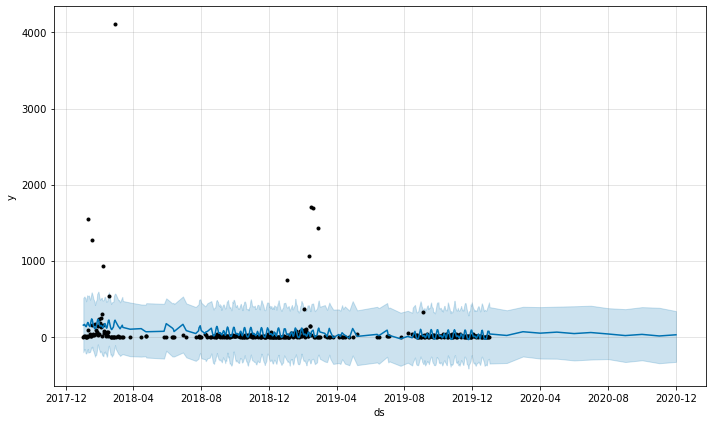

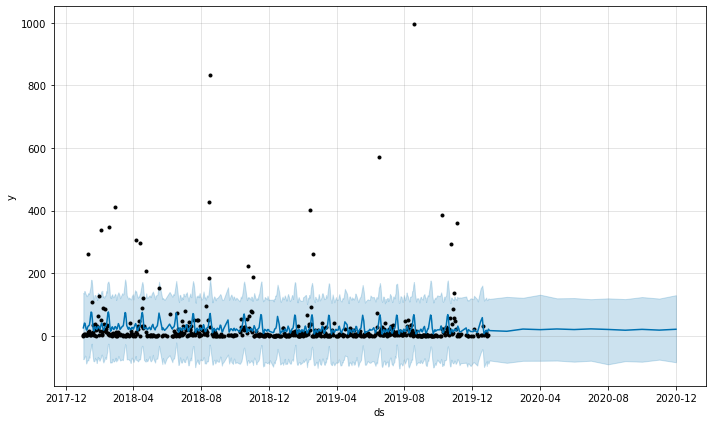

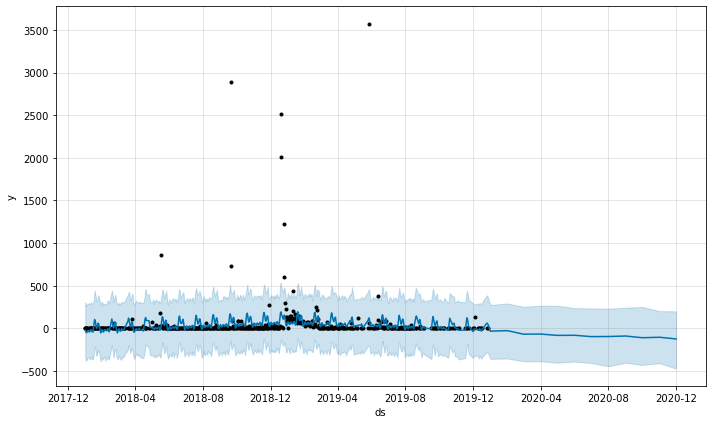

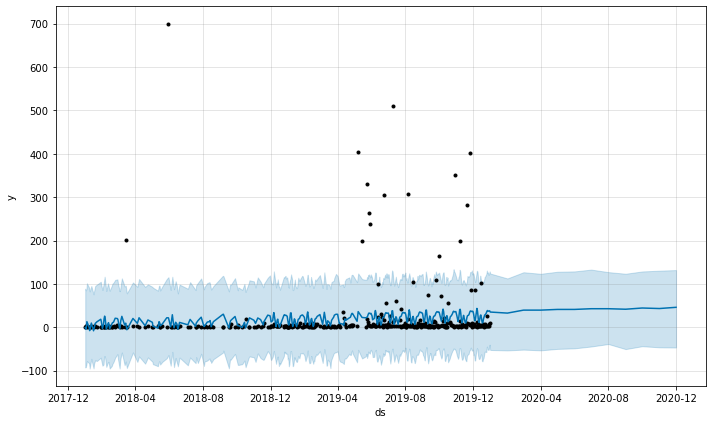

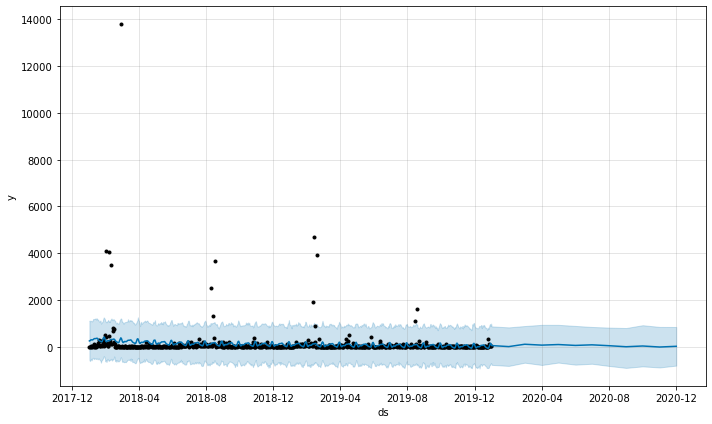

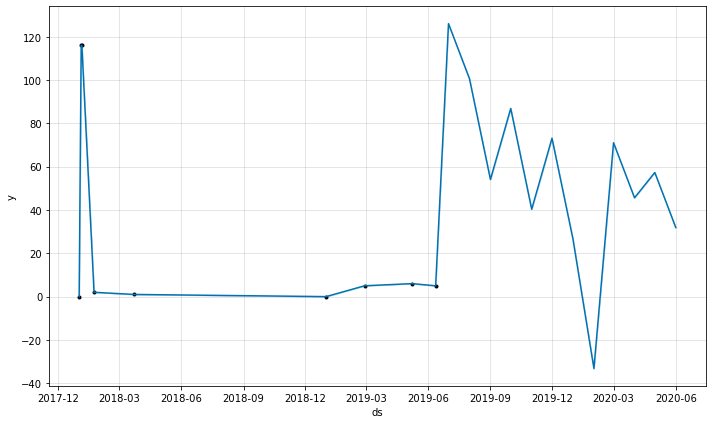

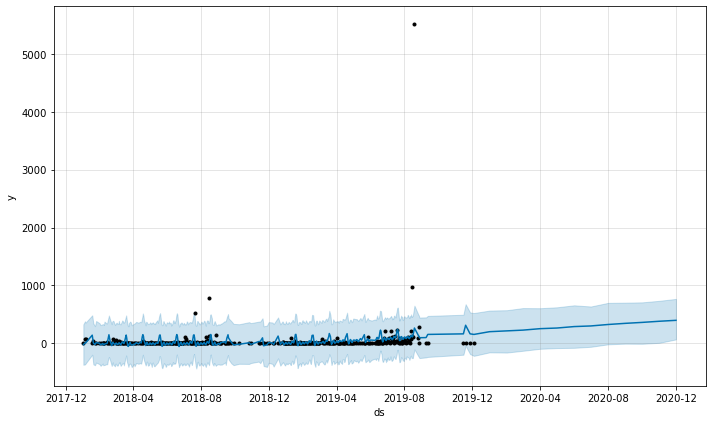

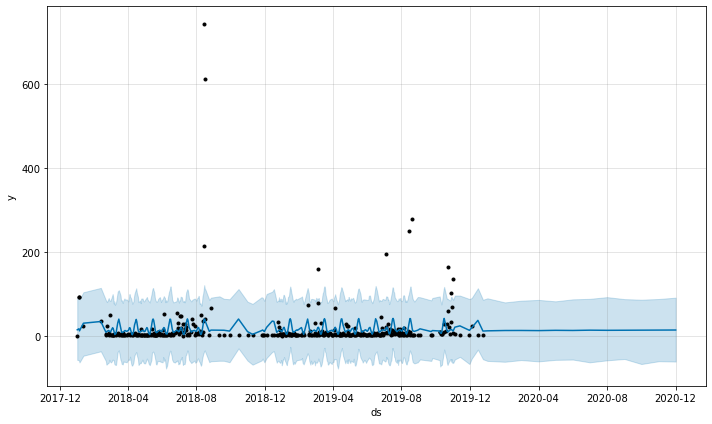

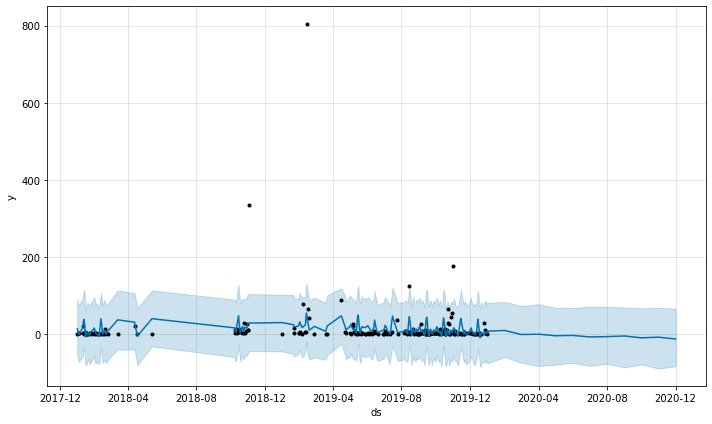

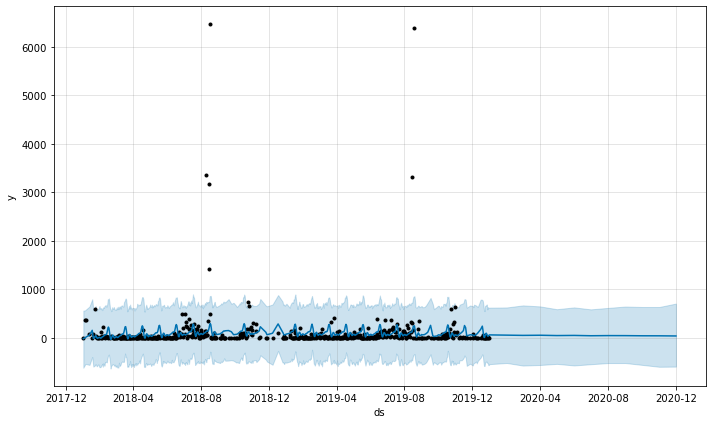

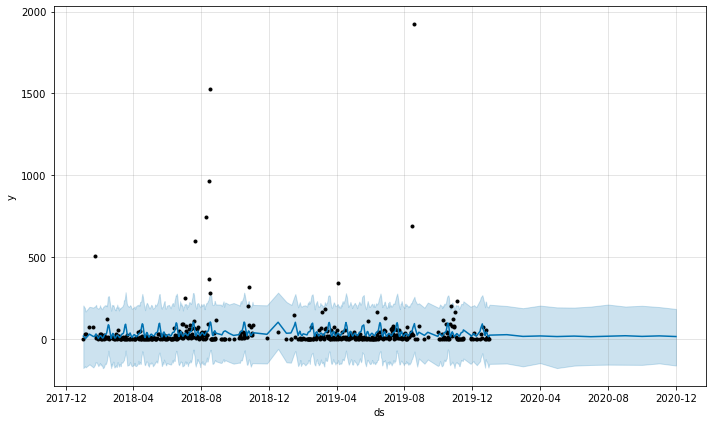

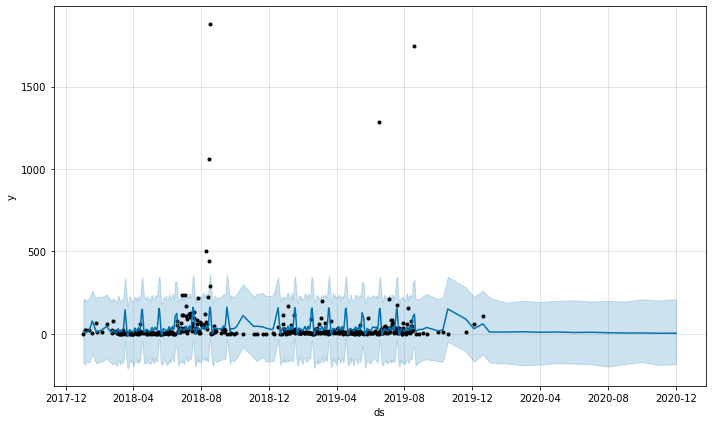

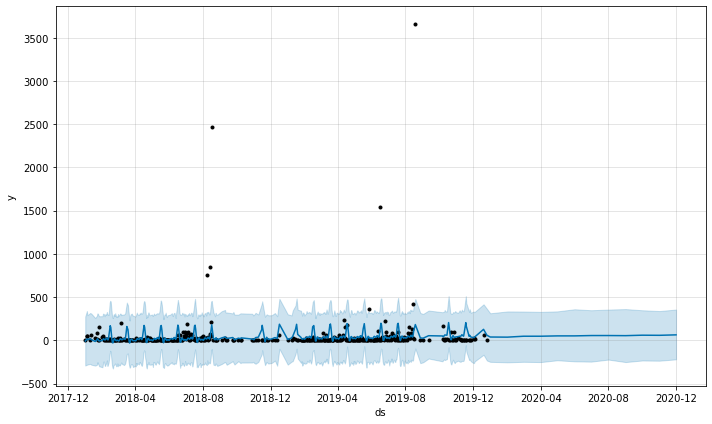

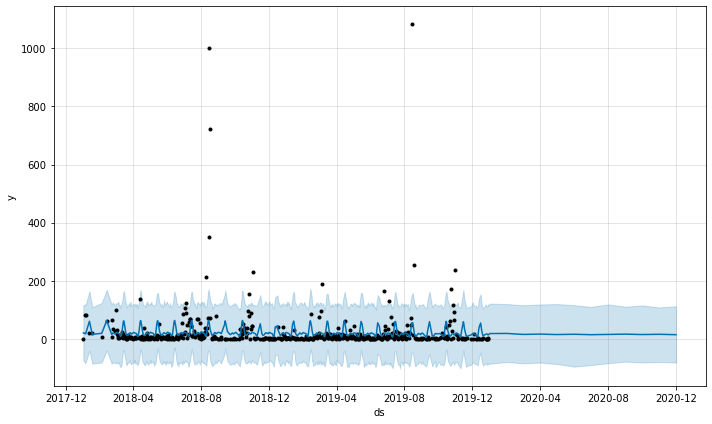

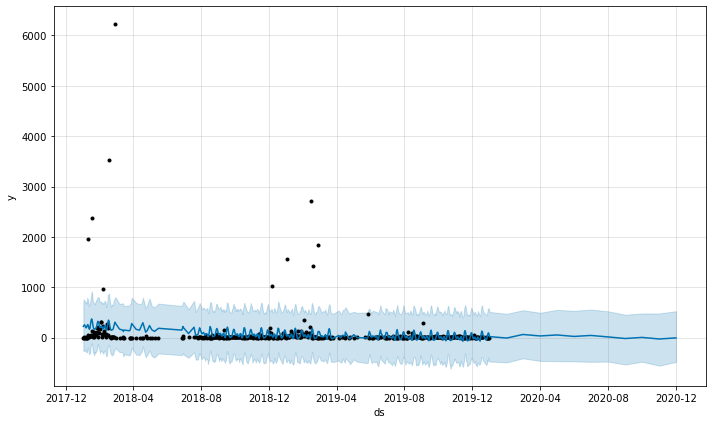

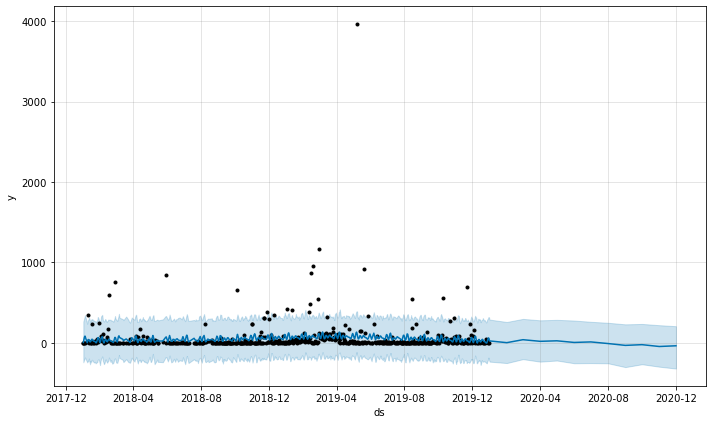

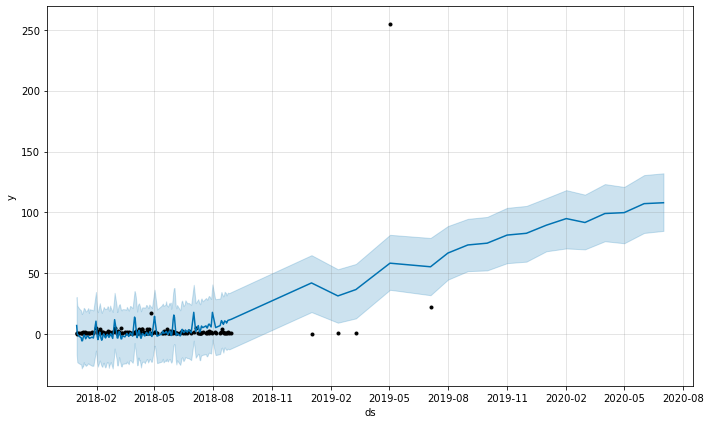

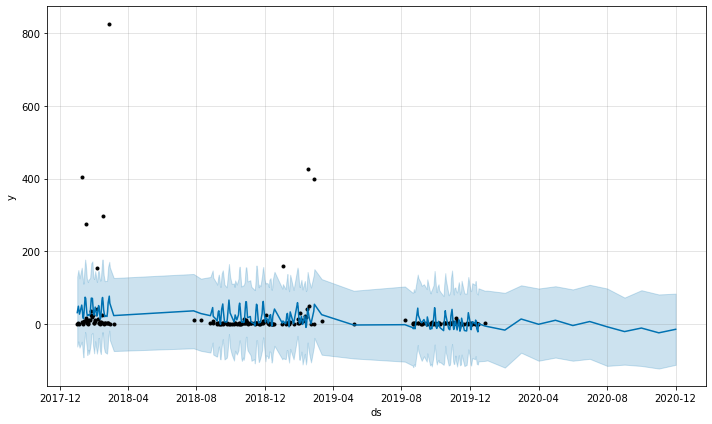

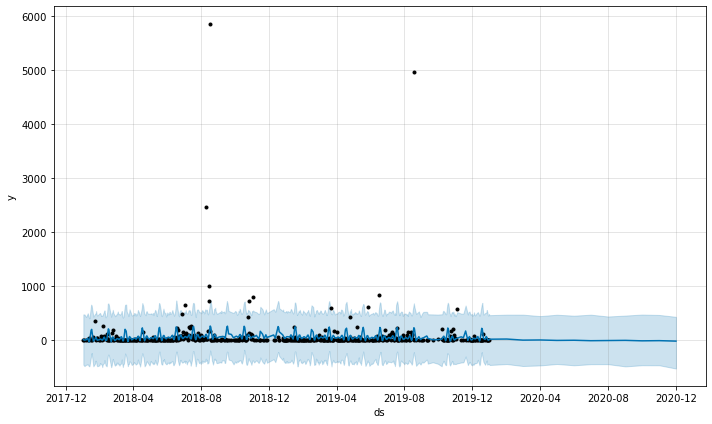

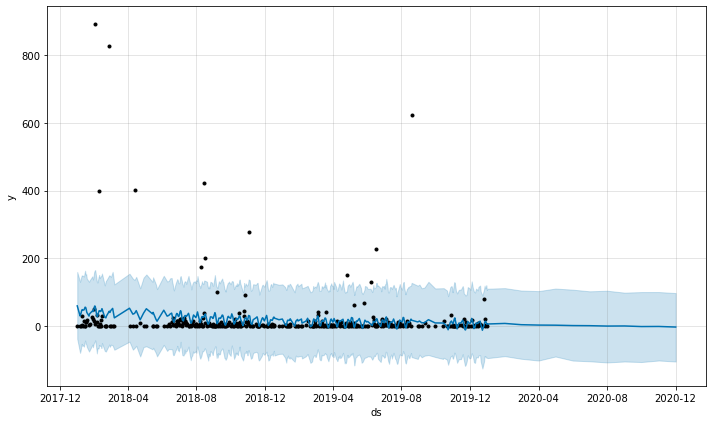

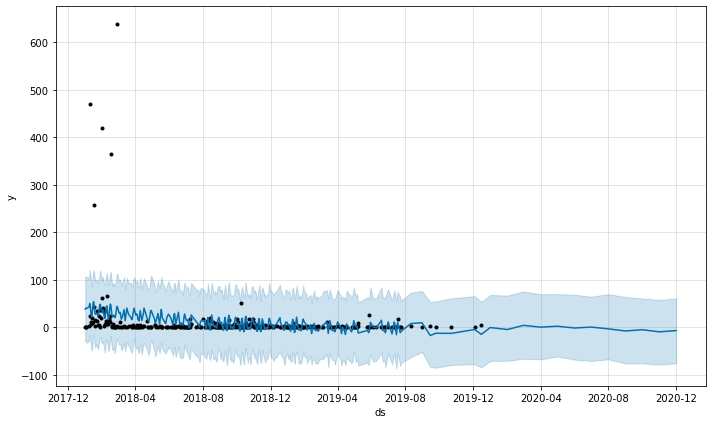

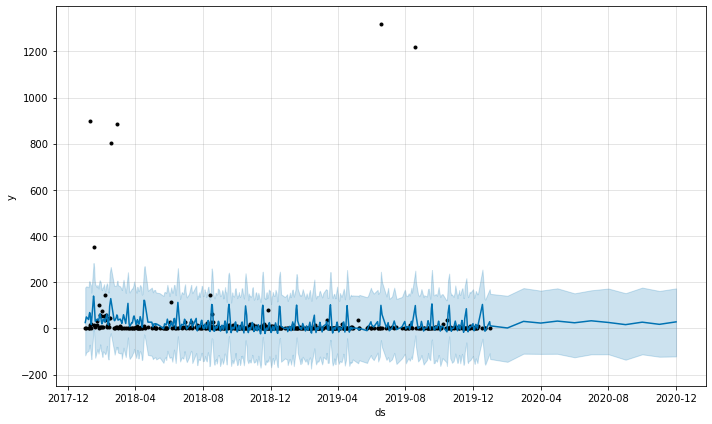

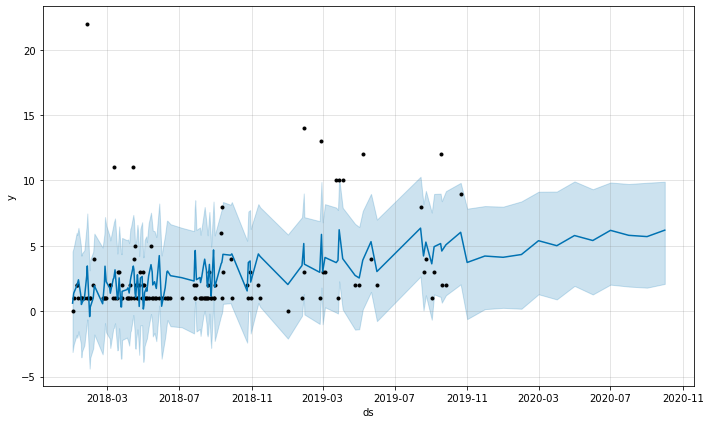

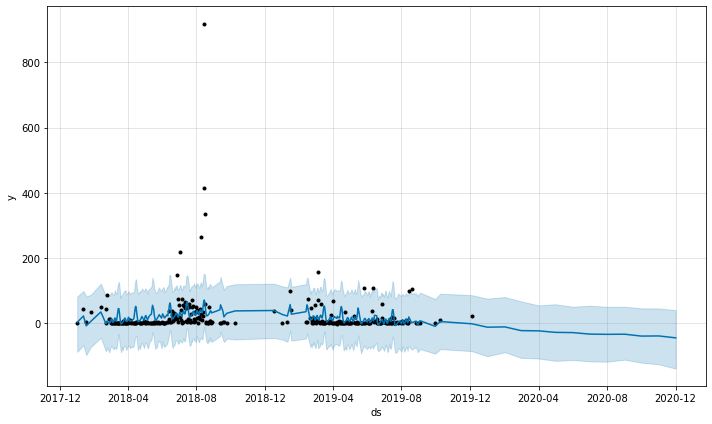

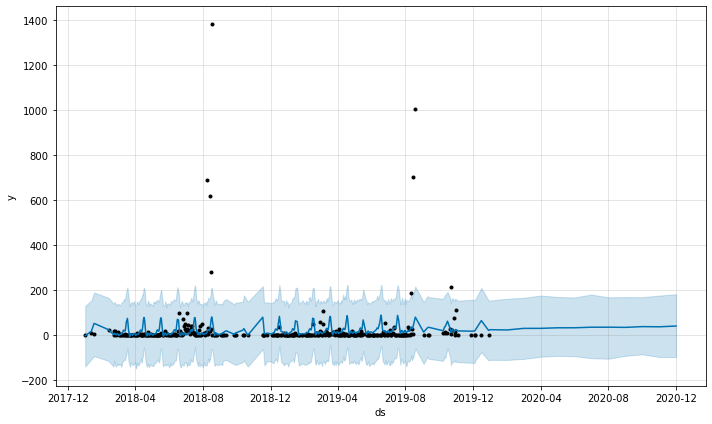

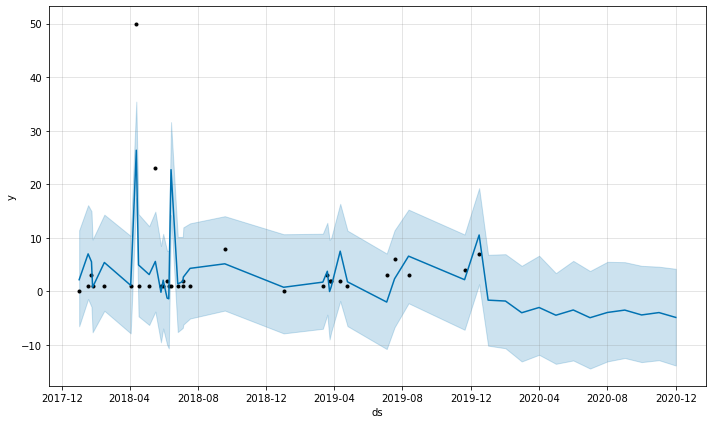

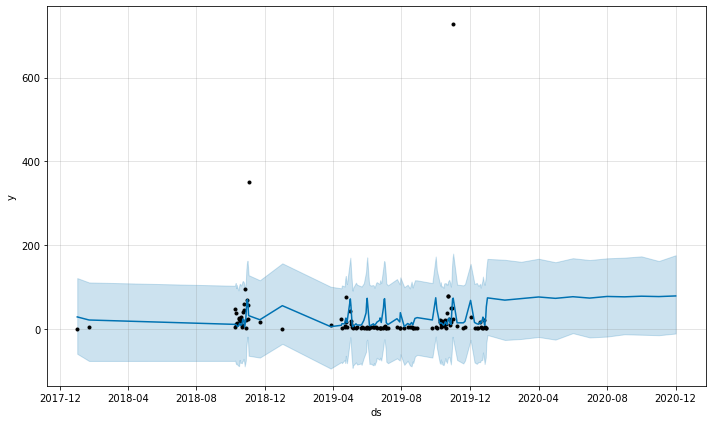

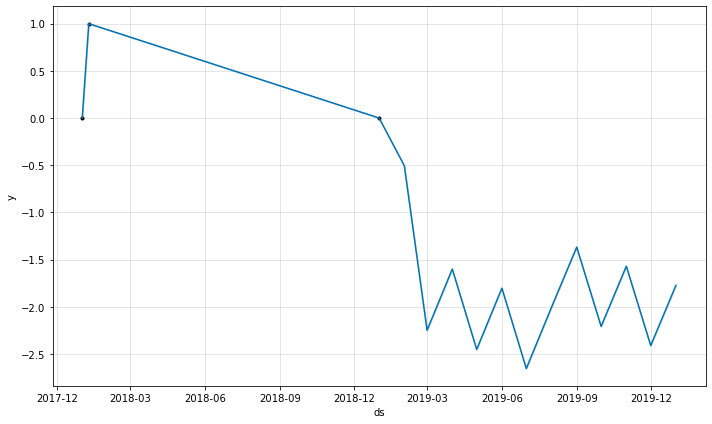

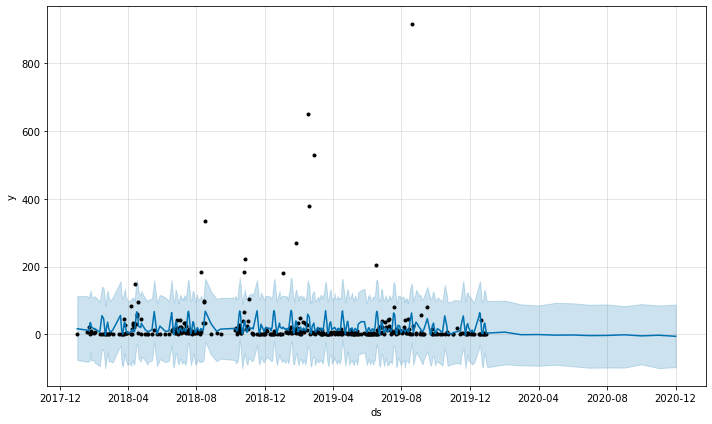

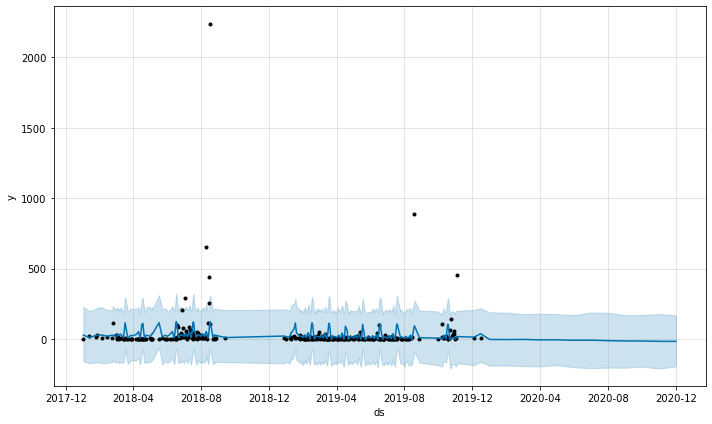

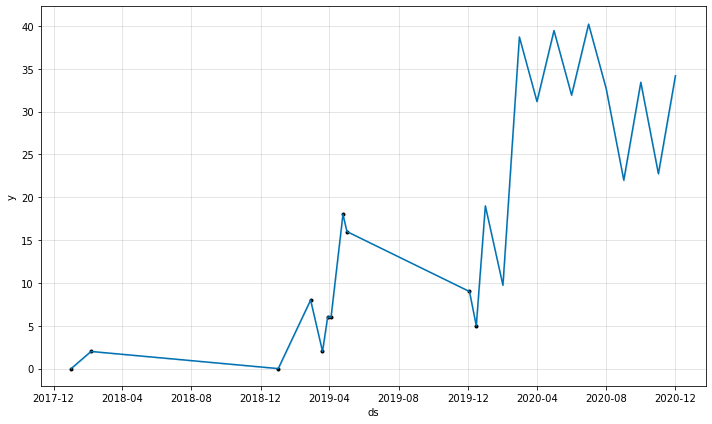

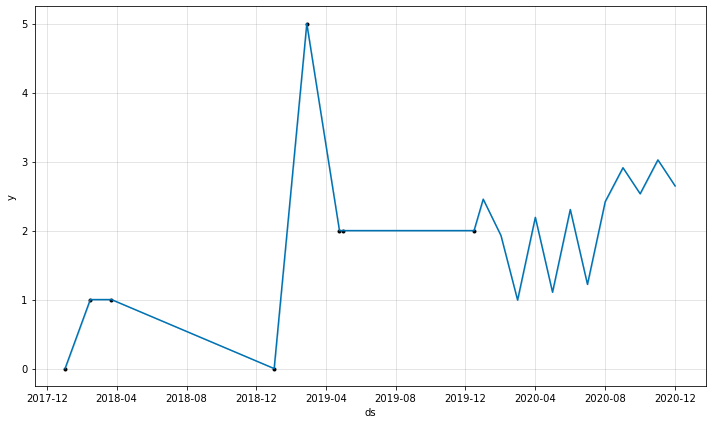

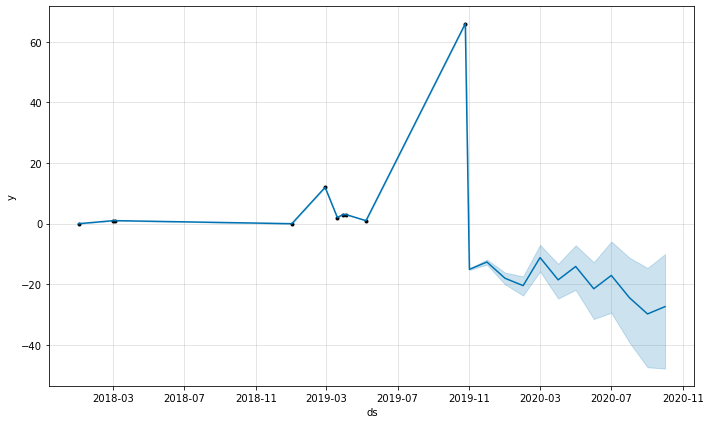

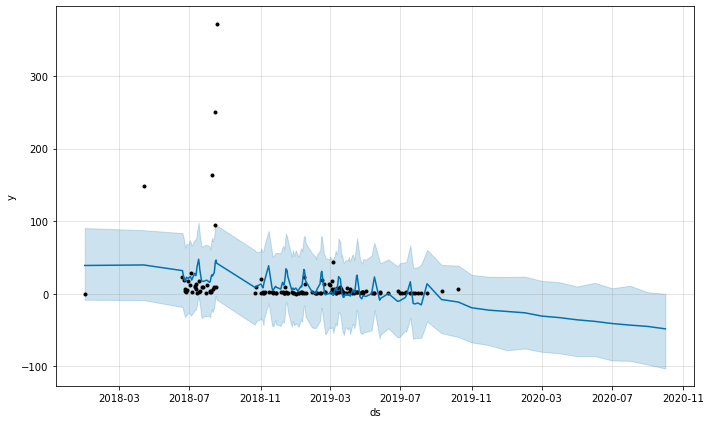

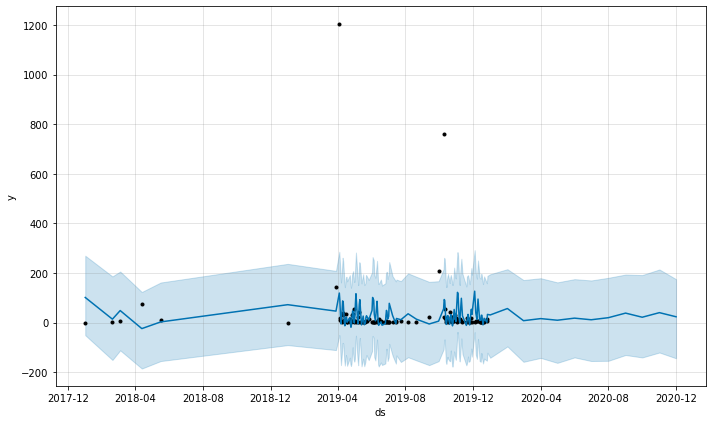

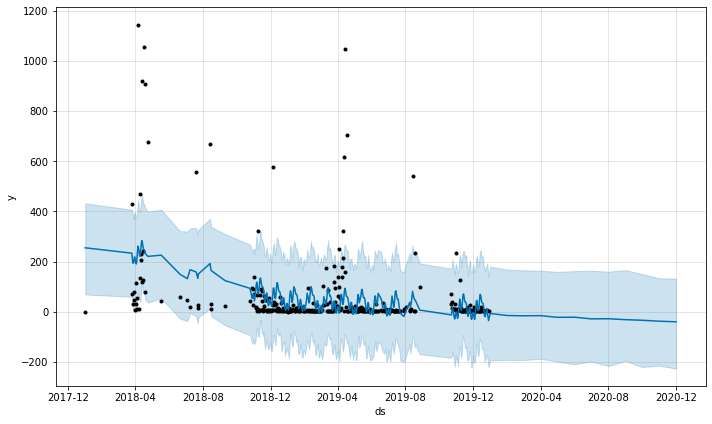

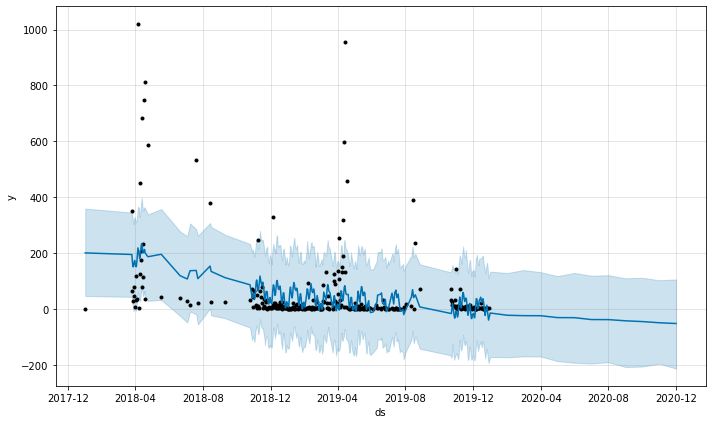

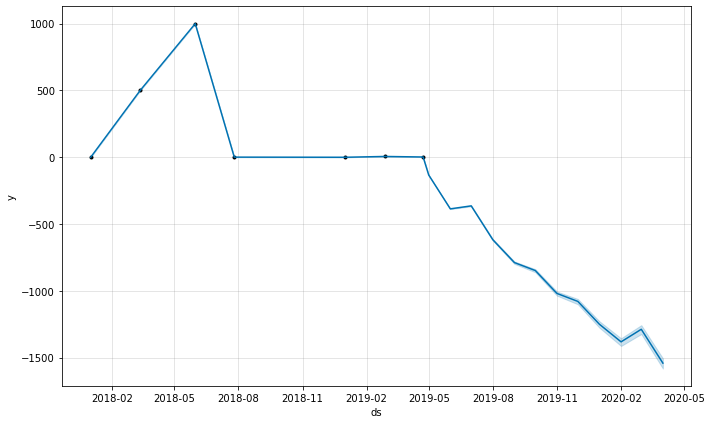

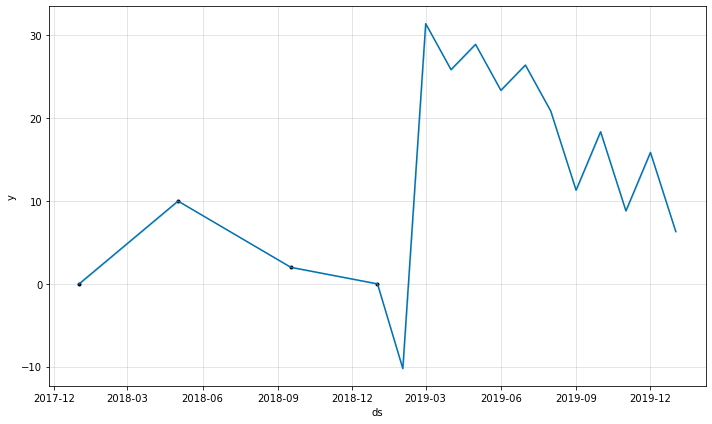

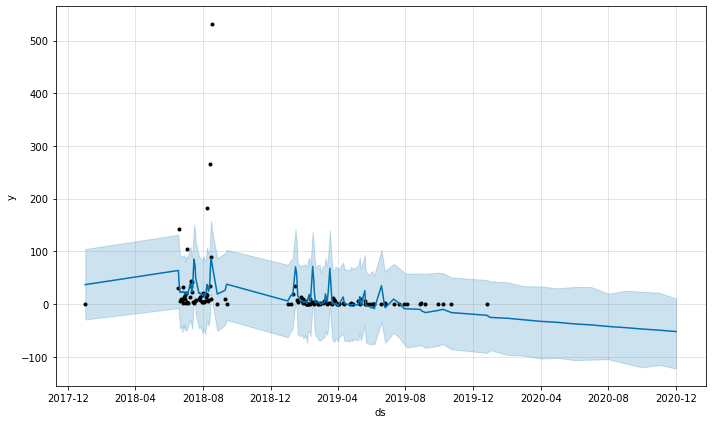

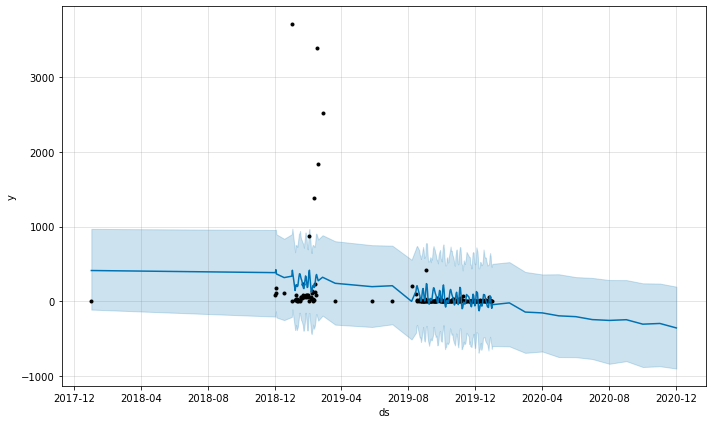

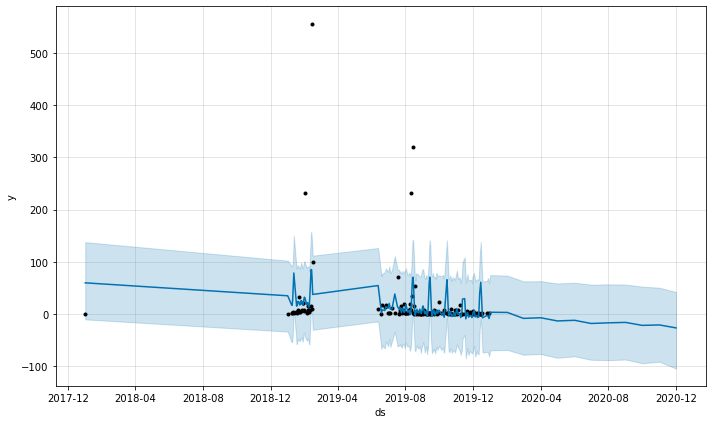

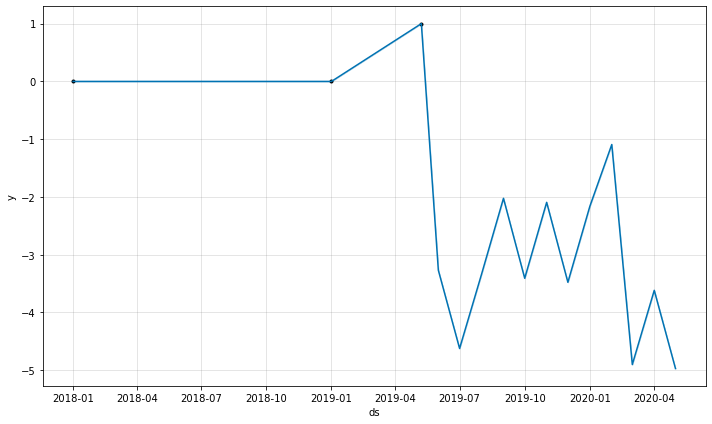

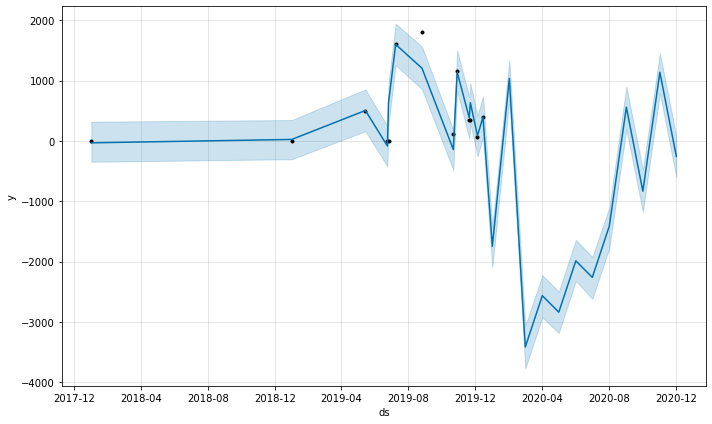

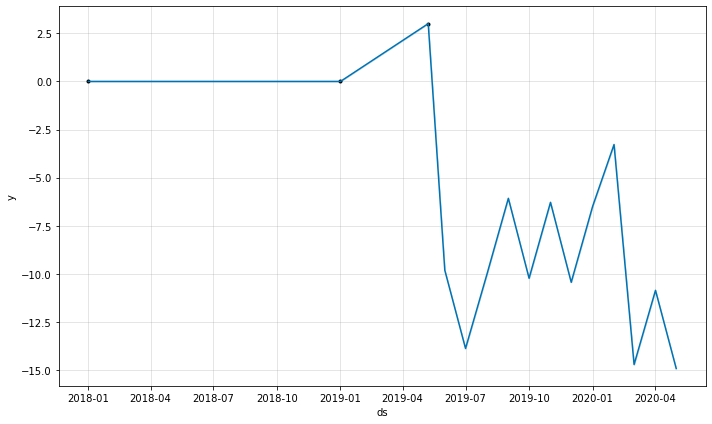

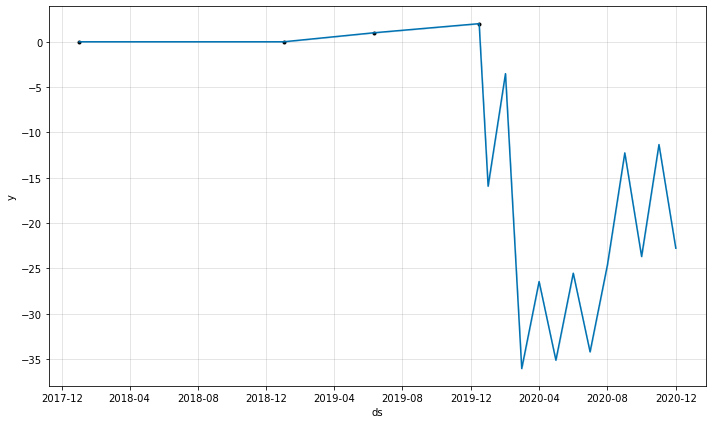

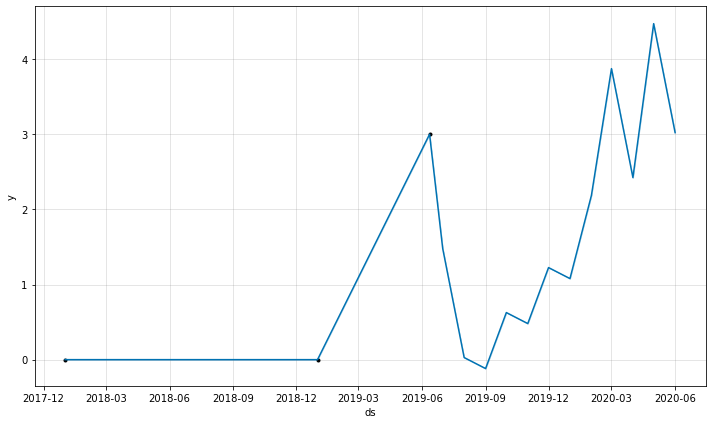

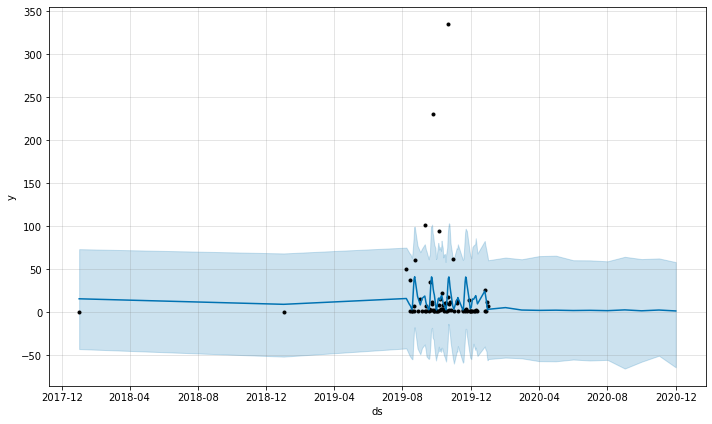

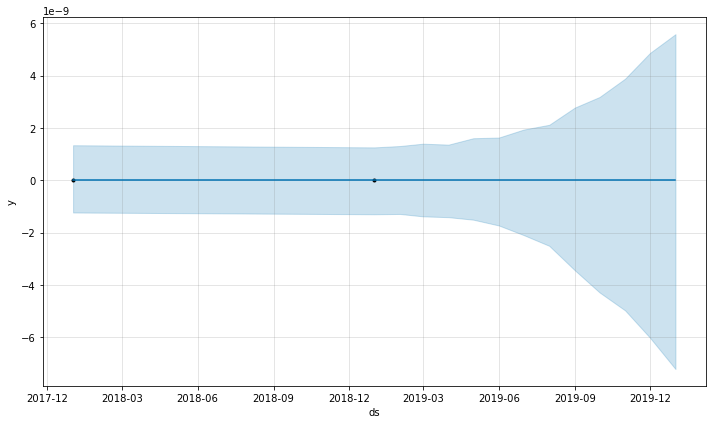

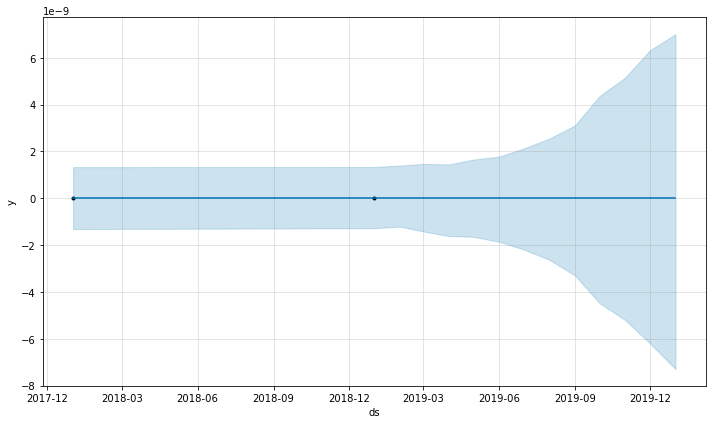

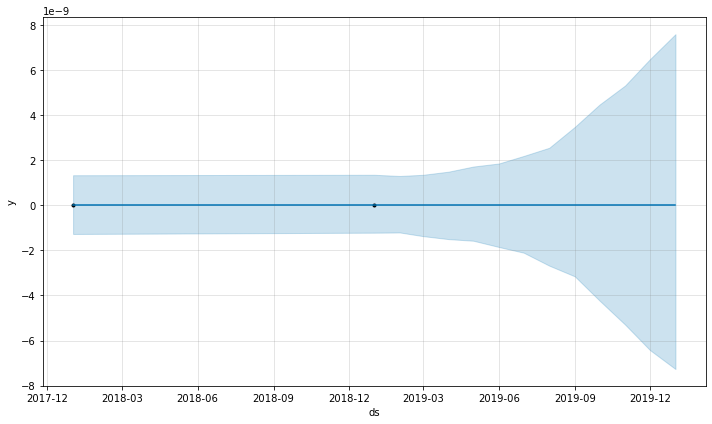

In [118]:
prediction_results_df = pd.DataFrame()

for index, row in article_dimension_df.iterrows():
    print(row[article_dimension])
    
    df_model = factOrder_df[factOrder_df[article_dimension] == row[article_dimension]]
    df_model = df_model.loc[:, ['DateOrderedKey', 'QuantityOrdered']]
    df_model = df_model.reset_index()
    df_model = df_model[['DateOrderedKey', 'QuantityOrdered']]
    df_model.columns = ['ds', 'y']
    #if df_model.shape[0] < 2:
    #    continue
    
    df_model = pd.concat([df_model, pd.DataFrame([{'ds' : pd.to_datetime(str(int(train_end_year) - 1) + '-01-01'), 'y' : 0}])])
    df_model = pd.concat([df_model, pd.DataFrame([{'ds' : pd.to_datetime(train_end_year + '-01-01'), 'y' : 0}])])
        
    train, test = CreateSplitTestAndTrainData(df_model)
           
    model = CreateModel(train)
    predictions = ModelPrediction(model)
    
    
    df_model_performance = pd.merge(test, predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-365:], on='ds')
    
    df_model_performance[article_dimension] = row[article_dimension]    
    prediction_results_df = pd.concat([prediction_results_df, df_model_performance]) 
    
    
    #df_model_cv = cross_validation(model, initial='365.25 days', period='180 days', horizon = '365.25 days')        
    #df_model_performance = performance_metrics(df_model_cv)
    
    #df_model_performance[article_dimension] = row[article_dimension]
    #prediction_results_df = pd.concat([prediction_results_df, df_model_performance])  
    

In [119]:
model.component_modes

{'additive': ['monthly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [120]:
prediction_results_df

ds     y      yhat  yhat_lower  yhat_upper ArticleGenre
0  2020-04-01   1.0  1.732795  -72.395522   70.465445       Övrigt
1  2020-06-01  -1.0  0.990996  -77.915943   72.502680       Övrigt
2  2020-07-01   6.0 -1.914049  -78.383012   68.349366       Övrigt
3  2020-09-01 -24.0  2.216395  -78.769603   72.956743       Övrigt
4  2020-10-01 -28.0 -0.492603  -73.470652   79.490506       Övrigt
..        ...   ...       ...         ...         ...          ...
2  2020-05-01   2.0  2.522970  -56.845636   65.833987    Postcards
3  2020-06-01  27.0  2.133829  -54.796219   60.543433    Postcards
4  2020-09-01   3.0  2.862831  -65.291913   64.517353    Postcards
5  2020-10-01   7.0  1.798240  -57.313934   61.866592    Postcards
6  2020-12-01   5.0  1.630445  -63.887733   58.351200    Postcards

[526 rows x 6 columns]

In [121]:
prediction_results_df[prediction_results_df[article_dimension] == 'SUNGLASSES']
#prediction_results_df[12:36]

Empty DataFrame
Columns: [ds, y, yhat, yhat_lower, yhat_upper, ArticleGenre]
Index: []

In [122]:
# Calculate MSE value
model_performance_MSE = mean_squared_error(prediction_results_df['y'], prediction_results_df['yhat'])
print('The MSE for the Prophet model is', model_performance_MSE)

# Calculate RMSE value
model_performance_RMSE = np.sqrt(model_performance_MSE)
print('The RMSE for the Prophet model is', model_performance_RMSE)

# Calculate MAE value
model_performance_MAE = mean_absolute_error(prediction_results_df['y'], prediction_results_df['yhat'])
print(f'The MAE for the Prophet model is', model_performance_MAE)

# Calculate MAPE value
model_performance_APE = np.abs((prediction_results_df['y'] - prediction_results_df['yhat']) / prediction_results_df['y'])
model_performance_MAPE = np.mean(model_performance_APE)
print(f'The MAPE for the Prophet model is', model_performance_MAPE)

#model_performance_MAPE = mean_absolute_percentage_error(prediction_results_df['y'], prediction_results_df['yhat'])
#print(f'The MAPE for the Prophet model is', model_performance_MAPE)

# Calculate MAPE value
model_performance_MDAPE = np.median(model_performance_APE)
print(f'The MAPE for the Prophet model is', model_performance_MDAPE)

The MSE for the Prophet model is 15607.659185937564
The RMSE for the Prophet model is 124.93061748801838
The MAE for the Prophet model is 57.7464149308626
The MAPE for the Prophet model is 9.08117395964816
The MAPE for the Prophet model is 2.8193206005218627


In [123]:
# Model performance by Dimension
model_performance_df = pd.DataFrame(pd.np.empty((0, 6)))
model_performance_df.columns = [article_dimension, 'MSE', 'RMSE', 'MAE', 'MAPE', 'MDAPE']

for index, row in article_dimension_df.iterrows():
    print(row[article_dimension])
    prediction_results_temp_df = prediction_results_df[prediction_results_df[article_dimension] == row[article_dimension]]    
    
    if not prediction_results_temp_df.empty:
               
        # Calculate MSE value
        model_performance_MSE = mean_squared_error(prediction_results_temp_df['y'], prediction_results_temp_df['yhat'])

        # Calculate RMSE value
        model_performance_RMSE = np.sqrt(model_performance_MSE)

        # Calculate MAE value
        model_performance_MAE = mean_absolute_error(prediction_results_temp_df['y'], prediction_results_temp_df['yhat'])

        # Calculate MAPE value
        model_performance_APE = np.abs((prediction_results_temp_df['y'] - prediction_results_temp_df['yhat']) / prediction_results_temp_df['y'])
        model_performance_MAPE = np.mean(model_performance_APE)

        # Calculate MDAPE value
        model_performance_MDAPE = np.median(model_performance_APE)

        new_record = {article_dimension : row[article_dimension], 'MSE' : model_performance_MSE, 'RMSE' : model_performance_RMSE,
                      'MAE' : model_performance_MAE, 'MAPE' : model_performance_MAPE, 'MDAPE' : model_performance_MDAPE}

        #new_records.append(new_record)


        model_performance_df = model_performance_df.append(new_record, ignore_index = True)

Övrigt
DRESSES LS WOVEN
SWEATSHIRTS
TEES LS
TEES SS
DRESSES LS
LEGGINGS
DRESSES SS
BEANIES
JACKETS UNPADDED
LEGGINGS NB


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  model_performance_df = pd.DataFrame(pd.np.empty((0, 6)))
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

SKIRTS
Dungaree
ONESIES
CAPS
BODY LS
SHIRT/BLOUSE
TROUSERS JERSEY
SWEATPANTS
Jumpsuits Baby
SWEATDRESSES
BODY WRAP
SWEATERS
OVERALLS UNPADDED
TIGHTS


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

BODY SS
JACKETS PADDED
SKIRTS WOVEN
BAGS
SOCKS
FLEECE
OTHER HOME
SWIMSUITS
GLOVES
TROUSERS WOVEN
BEDDINGS
Giftbox


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

CARDIGANS
SUNGLASSES
DRESSES STRAP
UV TOPS
JUMPSUITS
SHORTS
TANKS
SWIMSHORTS
RAIN & SUN HATS
SWIMPANTS
OVERALLS PADDED
OTHER ACCESSORIES
SHOES
TROUSERS PADDED
DRESSES SS WOVEN
SCARVES/BIBS


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

BABY BOOTS
TROUSERS UNPADDED
DENIM
Summersuit
UV SUITS
BABY KIT
BATH
Jacket
BODY WOVEN
SHORTS WOVEN
PLAYSUIT
OUTERWEAR
INTERIOR
ROBES
UNDERWEAR
TOP WCT


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

TROUSERS WCT
TOP
OTH
Caps
KNITTED HATS
BEANIE BABY
HOME
Paperbags store material
Tee
BOV
Jackets
Postcards
Party
Shoes
JUMPSUIT WOVEN


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_2052\3417707313.py:33: FutureWarning: The frame.append method is deprecated and will be re

In [124]:
model_performance_df

ArticleGenre            MSE        RMSE         MAE       MAPE  \
0             Övrigt     304.450991   17.448524   13.687872   1.175431   
1   DRESSES LS WOVEN    5536.690061   74.408938   54.653879  19.453575   
2        SWEATSHIRTS  104712.174259  323.592605  248.913524   4.371462   
3            TEES LS   23657.810221  153.810956  119.414984   5.332133   
4            TEES SS  259207.866527  509.124608  254.955834   5.968666   
..               ...            ...         ...         ...        ...   
57           TOP WCT    1726.754681   41.554238   38.874567  11.592134   
58      TROUSERS WCT    2522.899744   50.228475   47.565238  16.875464   
59      KNITTED HATS   64214.502008  253.405805  211.011737  58.381022   
60       BEANIE BABY     350.754944   18.728453   17.098709  10.516487   
61         Postcards      94.682021    9.730469    5.355252   0.680079   

        MDAPE  
0    1.037378  
1   10.745636  
2    2.800947  
3    1.190480  
4    2.383759  
..        ...  
57   7.057013  
58  13.005471  
59  50.426295  
60   7.729297  
61   0.673911  

[62 rows x 6 columns]

In [126]:
#model_performance_df.to_csv('model_performance_df.csv', index=False)